# Welcome to MagGeo  - Annotation Process 🌎📡

> **Authors**: Fernando Benitez, Urska Demsar, Jed Long

# Preface 

**MagGeo** - Annotation Program is a Python-based tool to help you to annotate/join a GPS track with the earth's magnetic field data from ESA Swarm Mission.  In combination The CHAOS-7 Geomagnetic Field Model the script will estimate the magnetic values from Swarm but at the ground level.

This program is based on Jupyter notebooks, which will guide you through each step and explain how the data is being manipulated and transformed to get the annotation result. If you have not worked with Jupyter Notebooks before, you can look at this resource and get the basic principles.

# Requirements to run MagGeo - Annotation Process

> ☝Before moving on with this script you might want to take a look at:

**1. Concept requirements**: The following concepts will be the basics elements you will need to get familiar with in order to understand the process behind MagGeo.

   1. Earth Magnetic Field
   2. Python - Pandas
   3. Jupyter Notebook

**2. Data requirements**:

   1. GPS track data in a csv format:

      There are three columns that  must be included to run the script. You need to make sure your GPS already include them. Latitude (degrees), Longitude (ITRFS) and timestamp form each row and measure.  Timestamp should follow the day/month/year Hour:Minute (**dd/mm/yyyy HH:MM**) format, Latitude and Longitude should be in decimal degrees ITFRS. Other Columns will be ignored. Here it is an example of how your GPS should looks like before load it into the script.

      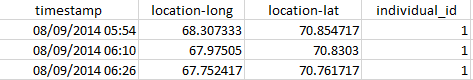

      Of course with knowledge of pandas and python you can manipulate your csv file and make the adjustment you need. Although if you want to run the script as it is conceived we would  recommend you to set your GPS track csv file in a text editor before you include it into the script.

   2. The magnetic data from Swarm will be downloaded using the VirES for Swarm client https://vires.services/oauth/accounts/login/. You will need to sign in there and get your token that allow you to get the data from the  VirES-Python-Client https://viresclient.readthedocs.io/en/latest/.  Here you can get the information about how to get the token: https://viresclient.readthedocs.io/en/latest/access_token.html

**3. Software Requirements**:

   1. Python 3.8

   2. Pandas 

   3. Nmpy

   4. Vires API for Python Client

   5. Jupyter Notebook
   
<div class="alert alert-warning" role="alert">
  <strong>The Earth's magnetic field varies both in space and time</strong>
    That is why the relevance of **MagGeo** helping researchers to understand the small variations of the geomagnetic field across an animal movement trajectory. In particular having the annotated geomagnetic components at the the date and time the GPS point was collected.  The following image can help you to understand how the geomagnetic components can be represented and how are computed.
</div>

# Running MagGeo - Annotation Process

You can run the Annotation process using two modes, Sequential and Parallel. Choose the mode of your preference.

* [1. Sequential Mode](#Sequential)
* [2. Parallel Mode](#Parallel)
* [Sequential Mode](MagGeo_Sequential_Mode.ipynb)

The following image will help you to understant what is the difference between the sequential and parallel mode, 

## Sequential Model <a class="anchor" id="Sequential"></a>

**General Description:** This script will led you through the required steps to annotate your GPS track with the earth magnetic field from Swarm Mission from European Spatial Agency. If you need more information about Swarm mission go to the Main document, then concept requirements. This script will use a sequential loop to run an annotation process for each GPS Point (row) from your data.

Each cell is proper described to present the process established. you can go through the cell you will also find inner comments `##` to describe any particular step that might be unclear. The process has several cells with commands only required to validated some intermediary results and help you to understand how the data is manipulated, those cells will include the following symbol 🔎 in the description. 


### Importing the requeried python libraries 

**1.** Importing the requeried packages and libraries

In [1]:
from viresclient import SwarmRequest
from viresclient import ClientConfig
import datetime as dt
import sys,os
from pathlib import Path
import pandas as pd
import numpy as np
# import xarray as xr
# from xarray import Dataset
import datetime, time
from datetime import timedelta
import math
import pathlib
from datetime import datetime
import time
import calendar
import datetime

### Reading the GPS track
The following steps will load the GPS track from a csv file, and set some requirements before download the data from Swarm.

**1.** Importing the GPS track. You can note that there is a folder to store the CSV file. Using `os.getcwd()` you can validate where the file is located.

In [2]:
gpsfilename="Data4Paper_915.csv"
def getGPSData():
    os.chdir("C:\\foss4guk19-jupyter-master\\Project_StAndrews\\VirES\\TestData")
    nfp = pd.read_csv(gpsfilename, parse_dates=[0], encoding='utf-8', dayfirst=True)
    gpsData = pd.DataFrame({'gpsLat':nfp['location-lat'], 'gpsLong': nfp['location-long'], 'gpsDateTime':nfp['timestamp']})
    return gpsData

In [3]:
# Calling the previous function to get the track as Dataframe.
GPSData = getGPSData()
GPSData.head()

,gpsLat,gpsLong,gpsDateTime
0,70.854717,68.307333,2014-09-08 05:54:00
1,70.830300,67.975050,2014-09-08 06:10:00
2,70.761717,67.752417,2014-09-08 06:26:00
3,70.686517,67.561983,2014-09-08 06:42:00
4,70.685450,67.548317,2014-09-08 07:14:00


**2.** Setting the date and time attributes for the requerided format and computing the epoch column. Values like Maximum and Minimun Date and time are also calculated.

In [4]:
#3.1 Convert the gpsDateTime to datetime python object
GPSData['gpsDateTime'] = pd.to_datetime(GPSData['gpsDateTime'], format='%d/%m/%Y %H:%M')
GPSData['gpsDateTime'] = GPSData['gpsDateTime'].map(lambda x: x.replace(second=0))
GPSData['gpsLat'] = GPSData['gpsLat'].astype(float)
#3.2 Adding new column epoch, will be usefuel to compare the date&time o each gps point againts the gathered swmarm data points
GPSData['epoch'] = GPSData['gpsDateTime'].astype('int64')//1e9
GPSData['epoch'] = GPSData['epoch'].astype(int)
#3.3 Computing Date and Time columns
GPSData['dates'] = GPSData['gpsDateTime'].dt.date
GPSData['times'] = GPSData['gpsDateTime'].dt.time
#3.4 Maximum and Minimum values
MinDateTime = min(GPSData['gpsDateTime'])
MaxDateTime = max(GPSData['gpsDateTime'])
dt_object1 = MinDateTime.to_pydatetime()
dt_object2 = MaxDateTime.to_pydatetime()
startDate = MinDateTime.date()
endDate = MaxDateTime.date()
MinTime=MinDateTime.time()
MaxTime=MaxDateTime.time()

### Validating the proper amount of Swarm messures
The annotation process apply an interpolation process which require for each GPS point time a set of Swarm points in the range of at least 4 hours before and 4 hours after each GPS Point time. To guarantee that all the GPS points have the enough amount of satellites measures.

**1**. The following loop is identifiying the time and validating if the time is less than 4:00 hours and more than 20:00 hours to bring one extra day of data. The result of this validation is written in a empty python list which will be later validated to get the unique dates avoing to download data for the same day and reducing the the downloand time process.

In [5]:
datestimeslist = []
for index, row in GPSData.iterrows():
    datetimerow  = row['gpsDateTime']
    daterow = row['dates']
    hourrow = row['times']
    hourrow = hourrow.strftime('%H:%M:%S')
    if hourrow < '04:00:00':
        date_bfr = daterow - (timedelta(days=1))
        datestimeslist.append(daterow)
        datestimeslist.append(date_bfr)
    if hourrow > '20:00:00':
        Date_aft = daterow + (timedelta(days=1))
        datestimeslist.append(daterow)
        datestimeslist.append(Date_aft)  
    else:
        datestimeslist.append(daterow)

**2.** Getting a list of unique dates, to being used to download the Swarm Data

In [6]:
def uniquelistdates(list): 
    x = np.array(list) 
    uniquelist = np.unique(x)
    return uniquelist

uniquelist_dates = uniquelistdates(datestimeslist)
uniquelist_dates

array([datetime.date(2014, 8, 18), datetime.date(2014, 8, 19),
       datetime.date(2014, 8, 25), datetime.date(2014, 8, 26),
       datetime.date(2014, 8, 27), datetime.date(2014, 8, 28),
       datetime.date(2014, 8, 29), datetime.date(2014, 8, 30),
       datetime.date(2014, 8, 31), datetime.date(2014, 9, 3),
       datetime.date(2014, 9, 5), datetime.date(2014, 9, 6),
       datetime.date(2014, 9, 8), datetime.date(2014, 9, 13),
       datetime.date(2014, 9, 14), datetime.date(2014, 9, 15),
       datetime.date(2014, 9, 17), datetime.date(2014, 9, 18),
       datetime.date(2014, 9, 19), datetime.date(2014, 9, 20),
       datetime.date(2014, 9, 21), datetime.date(2014, 9, 22),
       datetime.date(2014, 9, 23), datetime.date(2014, 9, 24),
       datetime.date(2014, 9, 25), datetime.date(2014, 9, 26),
       datetime.date(2014, 9, 27), datetime.date(2014, 9, 29),
       datetime.date(2014, 9, 30), datetime.date(2014, 10, 1),
       datetime.date(2014, 10, 2), datetime.date(2014, 10, 

### Fetching the data from Swarm and computing them at the ground level:  <a class="anchor" id="Fetching"></a>

Once the date and time columns have been defined, and the unique dates were identified the script can start the download process. Usually the data from Swarm is requested using only one satellite, however **MagGeo** will use the magnetic measures from the three satellite of the Swarm Mission. The following function (`GetSwarmData_and_residual`) is  mainly divided in two parts. Get the data from Swarm including the residuals and then compute the magnetic field at the ground level using the residuals from the CHAOS model. 

<div class="alert alert-warning" role="alert">
  <strong>🔎 CHAOS: </strong>
    <br>
is a comprehensive field model, containing the modelled contributions of the time-varying core, the static crustal field, the average time-varying magnetosphere. We show calculation of the residuals (adding this parameter `residuals=True`) which means: data -  <strong>CHAOS(Core+Static)</strong> and  data -<strong>CHAOS(Core+Static+Magnetosphere)</strong>
</div>

The **CHAOS** model is available on the server as model variables:

- CHAOS-Core: SH degree 1-20
- CHAOS-Static: SH degree 21-110
- CHAOS-MMA-Primary: Magnetosphere external field, SH degree 1-2
- CHAOS-MMA-Secondary: Magnetosphere internal induced field, SH degree 1-2

We will use the abbreviations:

- MCO: core model
- MLI: lithosphere model (i.e. static)
- MMA: magnetosphere model

<div class="alert alert-info" role="alert">
This will compute the magnetic measures not at the height of the three satellites ( 450 km and 550 km above the sea level) and will approximate calculate the Swarm measures at the ground level, making the measures more precise to any GPS trajectory.
</div>

**1.** Defining fucntion to fetch Swarm data and compute the magnetic values at the ground level

In [7]:
%%time

import chaosmagpy as cp
from chaosmagpy import load_CHAOS_matfile
from chaosmagpy.data_utils import mjd2000


def GetSwarmData_and_residuals (startDateTime, endDateTime, mid_date):
    
    # 1. Starting the Swarm Request.
    #    `SwarmRequest` is an object provided by the VirES interface, we need time objects 
    #    to be used by `SwarmRequest.get_between()` in this case we will fetch every date one day per loop (i.e. around 15 orbits)
    #    of the scalar (`F`) measurements from Swarm Satellites. The data are then loaded as a `xarray` dataframe.
    #    donwsamples the data to 60 seconds, from the `MAGx_LR` product having default of 1 second.
    #    https://viresclient.readthedocs.io/en/latest/available_parameters.html
    
    requestA = SwarmRequest() 
    requestB = SwarmRequest()
    requestC = SwarmRequest()
    
    #2. Loading the matlab CHAOS model to compute the residuals and resting those values from the residuals from Swarm.
    model = load_CHAOS_matfile('C:\\foss4guk19-jupyter-master\\Project_StAndrews\\Parallel\\CHAOS-7.mat') 
    #For more information about the magnetic models go to: https://www.space.dtu.dk/english/research/scientific_data_and_models/magnetic_field_models
    
    #3. Getting the data for Satellite A. 
    requestA.set_collection("SW_OPER_MAGA_LR_1B")
    requestA.set_products(
        measurements=[
            'B_NEC', #The Magnetic values are in NEC system (North, East, Centre)

        ],

        models = [
            '"CHAOS_MCO_MLI" = "CHAOS-Core" + "CHAOS-Static"',
            '"CHAOS_MCO_MLI_MMA" = "CHAOS-Core" + "CHAOS-Static" + "CHAOS-MMA-Primary" + "CHAOS-MMA-Secondary"'
        ],
        residuals=True, #Brining the residuals.
        sampling_step="PT60S", #Get the data every 60 seconds. 
    )
    
    #4. Defining an array to store the data request for Satellite A, based on the starting Data and time.
    #   You can display dsA to get an idea of how the data is requested.
    dsA = requestA.get_between(
        start_time=startDateTime,
        end_time=endDateTime
    ).as_xarray()
    
    
    #5. Brining the residuals from CHAOS Model, the one was loaded in step No 2.
    
    thetaA = 90-dsA["Latitude"].values  # colatitude in degrees (colatitude = 90-latitude)
    phiA = dsA["Longitude"].values  # longitude in degrees
    time = mjd2000(mid_date.year, mid_date.month, mid_date.day)  * np.ones((thetaA.size,)) # The core field does not change over a day so pick a single time
    radius = 6371.2 * np.ones((thetaA.size,))
    # this is the Earth's average radius - 
    # if you need to add the heigth of your GPS trajectory, you need to put in the bird's height in km above the centre of the Earth
    # and parsing this values as one extra parameter of this fuction. 
   
    #6. The residuals from the model CHAOS are computed.  
    B_r_coreA, B_t_coreA, B_phi_coreA = model.synth_values_tdep(time,radius, thetaA, phiA)
    B_r_crustA, B_t_crustA, B_phi_crustA = model.synth_values_static(radius, thetaA, phiA)
    
    #7. Once the xarray is created, we can extracted the variables included using xarray.DataArray object e.g. dsA["Latitude"]).
    # The SwarmRequest inside in the dsA xarray has Timestamp as index. The vector measurements have 3 dimensions which are 
    # the three components (N, E, C). One dimension can be extracted like indexing into a numpy ndarray. The N (Northwards)
    # component is accessed as xarray["variable"][:, index]:
    
    B_r_swarmA, B_t_swarmA, B_phi_swarmA = -dsA["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 2], -dsA["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 0], dsA["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 1]
   
    #8. Once the residuals are computed and extracted for Swarm data stored temporaly in xarray. The Magnetic fiel on
    #   the ground is computed.
    B_r_groundA = B_r_coreA + B_r_crustA - B_r_swarmA #(-Z)
    B_t_groundA = B_t_coreA + B_t_crustA - B_t_swarmA #(-X)
    B_phi_groundA = B_phi_coreA + B_phi_crustA - B_phi_swarmA #(Y)
    
    #9. Due to Swarm data are in NEC (or XYZ) while the CHAOS model outputs the radial, theta and phi components which are Br = -Z, 
    #   Bt = -X and BP = Y
    C_groundA = -B_r_groundA   #Z
    N_groundA = -B_t_groundA   #X
    E_groundA = B_phi_groundA  #Z
    
    #10. To finish the transformation and extraction process, a final dataframe is created, setting clear names and including
    #    a epoch columns to be the dataframe index.
    
    SwarmDataA = pd.DataFrame({'Na':N_groundA,'Ea':E_groundA, 'Ca':C_groundA, 'Ta':N_groundA['Timestamp'], 'LatA':dsA['Latitude'], 'LongA':dsA['Longitude']})
    SwarmDataA['epoch'] = SwarmDataA['Ta'].astype('int64')//1e9
    SwarmDataA['epoch'] = SwarmDataA['epoch'].astype(int)
    SwarmDataA.set_index("epoch", inplace=True)
    
    #11. The same process will take place for the satellites Bravo and Charlie.
    
    ######Request for Sat B #########
    requestB.set_collection("SW_OPER_MAGB_LR_1B")
    requestB.set_products(
        measurements=[
            'B_NEC',

        ],
        models = [
            '"CHAOS_MCO_MLI" = "CHAOS-Core" + "CHAOS-Static"',
            '"CHAOS_MCO_MLI_MMA" = "CHAOS-Core" + "CHAOS-Static" + "CHAOS-MMA-Primary" + "CHAOS-MMA-Secondary"'
        ],
        residuals=True, 
        sampling_step="PT60S",
    )

    dsB = requestB.get_between(
        start_time= startDateTime,
        end_time= endDateTime
    ).as_xarray()
    
    # Getting the residuals for SatB...
    thetaB = 90-dsB["Latitude"].values  # colatitude in degrees (colatitude = 90-latitude)
    phiB = dsB["Longitude"].values  # longitude in degrees
    time = mjd2000(mid_date.year, mid_date.month, mid_date.day)  * np.ones((thetaB.size,))
    radius = 6371.2 * np.ones((thetaB.size,))  
    B_r_coreB, B_t_coreB, B_phi_coreB = model.synth_values_tdep(time,radius, thetaB, phiB)
    B_r_crustB, B_t_crustB, B_phi_crustB = model.synth_values_static(radius, thetaB, phiB)
    
    B_r_swarmB, B_t_swarmB, B_phi_swarmB = -dsB["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 2], -dsB["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 0], dsB["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 1]


    B_r_groundB = B_r_coreB + B_r_crustB - B_r_swarmB #(-Z)
    B_t_groundB = B_t_coreB + B_t_crustB - B_t_swarmB #(-X)
    B_phi_groundB = B_phi_coreB + B_phi_crustB - B_phi_swarmB #(Y)
    
    C_groundB = -B_r_groundB   #Z
    N_groundB = -B_t_groundB   #X
    E_groundB = B_phi_groundB  #Y
    
    SwarmDataB = pd.DataFrame({'Nb':N_groundB,'Eb':E_groundB, 'Cb':C_groundB, 'Tb':N_groundB['Timestamp'], 'LatB':dsB['Latitude'], 'LongB':dsB['Longitude']})
    SwarmDataB['epoch'] = SwarmDataB['Tb'].astype('int64')//1e9
    SwarmDataB['epoch'] = SwarmDataB['epoch'].astype(int)
    SwarmDataB.set_index("epoch", inplace=True)
  
    ######Request for Sat C #########
    requestC.set_collection("SW_OPER_MAGC_LR_1B")
    requestC.set_products(
        measurements=[
            'B_NEC',

        ],
        models = [
            '"CHAOS_MCO_MLI" = "CHAOS-Core" + "CHAOS-Static"',
            '"CHAOS_MCO_MLI_MMA" = "CHAOS-Core" + "CHAOS-Static" + "CHAOS-MMA-Primary" + "CHAOS-MMA-Secondary"'
        ],
        residuals=True,
        sampling_step="PT60S",
    )

    dsC = requestC.get_between(
        start_time=startDateTime,
        end_time=endDateTime
    ).as_xarray()
    
    #Getting the residuals for SatC...
    thetaC = 90-dsC["Latitude"].values  # colatitude in degrees (colatitude = 90-latitude)
    phiC = dsC["Longitude"].values  # longitude in degrees
    time = mjd2000(mid_date.year, mid_date.month, mid_date.day)  * np.ones((thetaC.size,))
    radius = 6371.2 * np.ones((thetaC.size,)) 

    B_r_coreC, B_t_coreC, B_phi_coreC = model.synth_values_tdep(time,radius, thetaC, phiC)
    B_r_crustC, B_t_crustC, B_phi_crustC = model.synth_values_static(radius, thetaC, phiC)
    
    B_r_swarmC, B_t_swarmC, B_phi_swarmC = -dsC["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 2], -dsC["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 0], dsC["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 1]

    B_r_groundC = B_r_coreC+ B_r_crustC - B_r_swarmC #(-Z)
    B_t_groundC = B_t_coreC + B_t_crustC - B_t_swarmC #(-X)
    B_phi_groundC = B_phi_coreC + B_phi_crustC - B_phi_swarmC #(Y)
    
    C_groundC = -B_r_groundC   #Z
    N_groundC = -B_t_groundC   #X
    E_groundC = B_phi_groundC  #Y
    
    SwarmDataC = pd.DataFrame({'Nc':N_groundC,'Ec':E_groundC, 'Cc':C_groundC, 'Tc':N_groundC['Timestamp'], 'LatC':dsC['Latitude'], 'LongC':dsC['Longitude']})
    SwarmDataC['epoch'] = SwarmDataC['Tc'].astype('int64')//1e9
    SwarmDataC['epoch'] = SwarmDataC['epoch'].astype(int)
    SwarmDataC.set_index("epoch", inplace=True)
    
    return SwarmDataA,SwarmDataB,SwarmDataC

Wall time: 1.49 s


**2.** Running the previous function, using a loop to going through every date in the unique date list. The **Vires client API**, requires a token. You can visit https://vires.services/ to get your own token. We highly recommend to use your own token to run the script to annotate your own GPS tracks. As we mentioned in the previous function definition the `SwarmRequest()` object have the `get_between` parameter which require a datetime variables. As the unique list is just a date python variable, we set a range of **24 hours to fetch the data** for one entire day at the every iteration. 

> 🔈 **Note:** 🔈 If you are aware that rather to fetching each day in the unique list we might set a minimum and maximum dates for the GPS track dates and thus fetch the whole data at once. Unfortunately due to the calculations required to compute the residual from the **local CHAOS model**, the number of days is limited to 10 days, including more days will raise a error into the `chaosmagpy` package. Likewise the amount of processing and downloading time is certainly very similar to fetch each date into a loop iteration. Therefore we have choose the most secure option.

> ⏳ **Be aware:** Due to the amount of dates the GPS track has (40 days) to fetch and compute the residuals, the time to process the sample data will take **approximately 20 minutes.**

In [8]:
%%time

hours_t_day = 24
hours_added = datetime.timedelta(hours = hours_t_day)

listdfa = []
listdfb = []
listdfc = []

cc = ClientConfig()
cc.set_site_config("https://vires.services/ows", token="rp-foC8gz-VTFz7He6SMPnQtKEpasEaB")
cc.default_url = "https://vires.services/ows"
cc.save()

for d in uniquelist_dates:
    print("Process for:",d,":" )
    startdate = datetime.datetime.combine(d, datetime.datetime.min.time())
    enddate = startdate + hours_added
    mid_date = d
    SwarmDataA,SwarmDataB,SwarmDataC = GetSwarmData_and_residuals(startdate, enddate,mid_date)
    listdfa.append(SwarmDataA)
    listdfb.append(SwarmDataB)
    listdfc.append(SwarmDataC)

Process for: 2014-08-18 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:03, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-08-19 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-08-25 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-08-26 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-08-27 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-08-28 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-08-29 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-08-30 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-08-31 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-09-03 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-09-05 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-09-06 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-09-08 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-09-13 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-09-14 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-09-15 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-09-17 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-09-18 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-09-19 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-09-20 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-09-21 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-09-22 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-09-23 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-09-24 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-09-25 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-09-26 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-09-27 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-09-29 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-09-30 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-10-01 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-10-02 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-10-03 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-10-04 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-10-05 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-10-06 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-10-10 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-10-13 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:03, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-10-14 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-10-15 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-10-22 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-10-23 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Process for: 2014-10-24 :


[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.129MB)
[1/1] Processing:  100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:0

Wall time: 23min 22s


**3.**  As you might noted in the previous cell we append the results from each iteration into a empty python list. In here we join a sequence of arrays along the 0 axis (by applying the `concant` function ), to get a pandas dataframe that contains the data for each Swarm satellite for all the unique dates we identified in the GPS track `datetime` column.

In [10]:
TotalSwarm_A = pd.concat(listdfa, join='outer', axis=0)
TotalSwarm_B = pd.concat(listdfb, join='outer', axis=0)
TotalSwarm_C = pd.concat(listdfc, join='outer', axis=0)

In [11]:
# Preview the compiled data from Satellite Alpha
TotalSwarm_A.head(10)

,Na,Ea,Ca,Ta,LatA,LongA
epoch,,,,,,
1408320000,8488.049419,3678.042652,56977.116484,2014-08-18 00:00:00,66.843847,-134.672531
1408320060,6299.698812,2809.512836,57193.881921,2014-08-18 00:01:00,70.654918,-133.562740
1408320120,4255.902625,1903.310746,57385.441493,2014-08-18 00:02:00,74.451293,-131.817227
1408320180,2557.202078,950.302393,57136.797202,2014-08-18 00:03:00,78.218581,-128.828006
1408320240,948.024938,29.660529,56837.439504,2014-08-18 00:04:00,81.915833,-122.893911
1408320300,-37.740767,-1153.060749,56610.055042,2014-08-18 00:05:00,85.371832,-107.323979
1408320360,1577.702484,-2222.685442,55856.246332,2014-08-18 00:06:00,87.354036,-51.425113
1408320420,4210.360659,-219.394370,55309.105382,2014-08-18 00:07:00,85.299258,3.178611
1408320480,5542.699912,1122.952796,54874.393158,2014-08-18 00:08:00,81.832625,18.336577


### Interpolation (ST-IDW) and Annnotation Processes: 

Once we have fetched the data we need for each point in the GPS Track and considering we have gathered the available data from the three satellites for one day ( *24 hours, every 60 seconds around 1440 Swarm measures per satellite*). Now we need to `filter` in space and time the available points to compute the magnetic values for each GPS point in its particular date and time. Therefore, before running the interpolation process we set **four** functions that will require the *latitude* and *longitude* and the *epoch* time of each GPS point to filter the Swarm points into what we called **Space-Time Cylinder**. The following picture can provide a better explanation about how the points inside the space-time cylinder are included or excluded. **Figure A**, shows the idea behid the interpolation process for each GPS point, fetching and processing the avaliable Swarm messuares by the three satellites. **Figure B**, illustrate the geometric components behing the space-time cylinder where the points are filtered and included in the interpolation process. Figure B, will help you to understand how the following functions compute the required parameters **Figure C** shows how the R of the Space-Time cylinder is based on the GPS point latitude. For more information about the time-space windows please read the full paper where we explain the details of it.

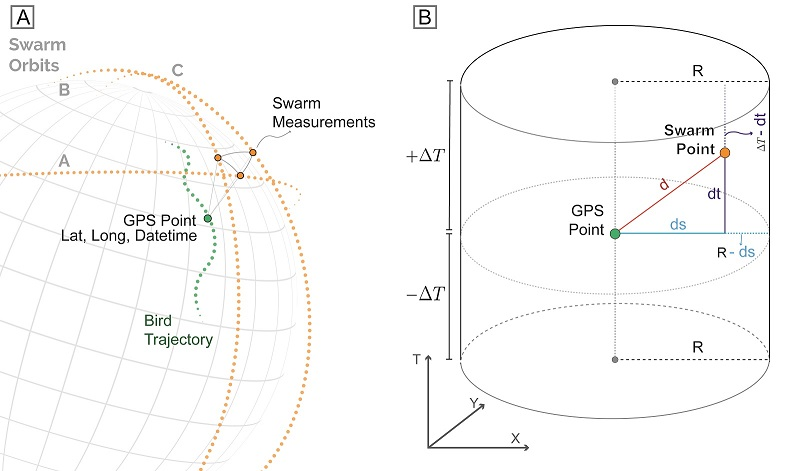
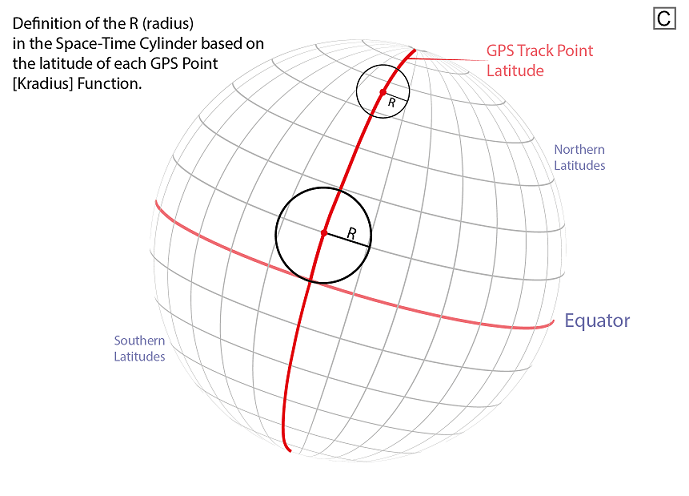

**1. distance_to_GPS** function: Is the function in charge to calculate the distance between each GPS Point and the Swarm Point.

**2. Kradius** function: Is the function in charge to compute the R (radius) value in the cylinder. The R value will be considered based on the latitude of each GPS Point.

**3. DistJ** function: This function will calculate the `d` value as the hypotenuse created in the triangle created amount the locations of the GPS point, the location of the Swarm points and the radius value. 

**4. DfTime_func** function: This is a time function to selected the points in the range of a the Delta Time -DT window. The Delta time window has been set as 4 hours for each satellite trajectory.

In [12]:
import pandas as pd
import numpy as np
import os

def distance_to_GPS(s_lat, s_lng, e_lat, e_lng): 
    # approximate radius of earth in km
    R = 6373.0
    s_lat = s_lat*(np.pi)/180.0                     
    s_lng = np.deg2rad(s_lng)     
    e_lat = np.deg2rad(e_lat)                       
    e_lng = np.deg2rad(e_lng)
    d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2
    return 2 * R * np.arcsin(np.sqrt(d))

def Kradius (lat):
    if 0 <= lat < 90 :
        #for Northern Latitudes 
        nlat = (-10 * lat) + 1800
        #print("The R on the North")
    if -90 < lat < 0:
        #for Southern Latitudes
        nlat = (10 * lat) + 1800
        #print ("The R on the South")
    return nlat

def DistJ(ds, r, dt, DT):
    eDist = np.sqrt((ds/r)**2 + (dt/DT)**2)
    return eDist

def DfTime_func (SwarmData, GPSTime, DT):
#     DT= 14400 #deltaT of 14400 secs, 4 hours, if the Period is 1s. 1440 for 10s of period. 240 for data every 60s.
    DataFrame_Per_Time = []
    for index in SwarmData.index:
        if index == GPSTime:
            DataFrame_Per_Time = pd.DataFrame(SwarmData.loc[index-DT:index+DT])
    return DataFrame_Per_Time

**5. SwarmMagAnnotation** function: Working as the main function for the annotation process, this functions meets the previous functions running the space-time window filters, and the computing the ST- IDW process. This function will run a interpolation process for each GPS Point considering only the Swarm points inside the Space-Time cylinder computed by the four previous functions. The return value will be an array with the values the annotated magnetic values for the GPS point. The function will be executed inside a loop going through the GPS track. This function is the annotation process per se, and through this process at first we run the interpolation getting the magnetic values in NEC reference frame and then we compute extra magnetic values that are useful to get a better understating of the earth magnetic field at this particular location, date and time.

In [13]:
def SwarmMagAnnotation (GPSLat,GPSLong,GPSDateTime,GPSTime, DT):
  
    # 1. Runnig the DfTime_func function to filter by the defined Delta Time.
    DfTimeA = DfTime_func(TotalSwarm_A,GPSTime,DT)
    DfTimeB = DfTime_func(TotalSwarm_B,GPSTime,DT)
    DfTimeC = DfTime_func(TotalSwarm_C,GPSTime,DT)
    #2. Computing the dt as the difference between the datetime and the datetime from swarm point. At this point
    #   we have filtered the swarm point by time.
    DfTimeA['dTa'] = (GPSTime - (DfTimeA.index))
    DfTimeB['dTb'] = (GPSTime - (DfTimeB.index))
    DfTimeC['dTc'] = (GPSTime - (DfTimeC.index))
    
    #3.Computing the ds
    # 3.1 Parsing the requieres parameters for distance_to_GPS function
    
    s_lat = GPSLat; e_lat = DfTimeA['LatA']; s_lng = GPSLong; e_lng = DfTimeA['LongA']  
    ## Running the function, based on the previous parameters, for SatA
    DfTimeA['distance']= distance_to_GPS(s_lat, s_lng, e_lat, e_lng) 
    
    s_lat = GPSLat; e_lat = DfTimeB['LatB']; s_lng = GPSLong; e_lng = DfTimeB['LongB']  
    # Running the function, based on the previous parameters, for SatB
    DfTimeB['distance']= distance_to_GPS(s_lat, s_lng, e_lat, e_lng)
    
    s_lat = GPSLat; e_lat = DfTimeC['LatC']; s_lng = GPSLong; e_lng = DfTimeC['LongC']  
    # Running the function, based on the previous parameters, for SatC
    DfTimeC['distance']= distance_to_GPS(s_lat, s_lng, e_lat, e_lng) 
    
    #3.2 Computing the R distance.
    DfTimeA['r']= Kradius(GPSLat)
    DfTimeB['r']= Kradius(GPSLat)
    DfTimeC['r']= Kradius(GPSLat)
    
    #3.3 Filtering row that only fall into the computed R value.
    dfFinalA=DfTimeA[DfTimeA['distance']<=DfTimeA['r']]
    dfFinalB=DfTimeB[DfTimeB['distance']<=DfTimeB['r']]
    dfFinalC=DfTimeC[DfTimeC['distance']<=DfTimeC['r']]
    
    #4. Calculating the number of points per satellite that have passed the Space and Time Windows.
    NumSatA = len(dfFinalA.index)
    NumSatB = len(dfFinalB.index)
    NumSatC = len(dfFinalC.index)
    TolSatPts = (NumSatA+NumSatB+NumSatC)
    
    #5. Getting ride of the unnecesarry columns.
    dfFinalA.drop(['Ta'], axis=1, inplace=True) 
    dfFinalB.drop(['Tb'], axis=1, inplace=True)
    dfFinalC.drop(['Tc'], axis=1, inplace=True)
    
    #6. Formatting columns for the filtered Swarm points to have the same schema.     
    dfFinalA.rename(columns={"LatA": "Lat", "LongA": "Long", "Na": "N", "Ea": "E", "Ca": "C", "dTa": "dT"}, inplace=True)
    dfFinalB.rename(columns={"LatB": "Lat", "LongB": "Long", "Nb": "N", "Eb": "E", "Cb": "C", "dTb": "dT"}, inplace=True)
    dfFinalC.rename(columns={"LatC": "Lat", "LongC": "Long", "Nc": "N", "Ec": "E", "Cc": "C", "dTc": "dT"}, inplace=True)
    
    #7. Combining the three satellited messures into a bigger dataframe that store all the Swarm points that were filtered. 
    frames = [dfFinalA, dfFinalB, dfFinalC] #List to index the specific SatId to the new full DF.
    SwarmData = pd.concat(frames, keys=['A', 'B', 'C'], sort=False)
    
    #8. Computing the minimum distance and the average distance.
    MinDistance = SwarmData['distance'].min()
    AvDistance = SwarmData['distance'].mean()
    
    #9. Computing the d (hypotenuse compused from the edges ds, dt values
    ds = SwarmData['distance']
    r = SwarmData['r']
    dt = SwarmData['dT']
    SwarmData['Dj']= DistJ(ds, r, dt, DT)
   
    #10 Calculating the weigth values based on the previuos parameters.
    SwarmData['W']= 1/((SwarmData['Dj'])**2)
    
    #11. Computing the Sum of weigths
    SumW = SwarmData['W'].sum()
    #12. Distribution of weigths
    SwarmData['Wj'] = SwarmData['W']/SumW
    
    #13. Computing the Magnetic componente based on the weigths prevoius weigths. 
    Ngps = (SwarmData['Wj']*SwarmData['N']).sum()
    Egps = (SwarmData['Wj']*SwarmData['E']).sum()
    Cgps = (SwarmData['Wj']*SwarmData['C']).sum()

    #14. Having Intepolated and weigth magnetic values, we can compute the other magnectic components. 
    Hgps = np.sqrt((Ngps**2)+(Egps**2))
    DgpsRad = np.arctan(Egps/Ngps)
    Dgps = np.degrees(DgpsRad)
    Fgps = np.sqrt((Ngps**2)+(Egps**2)+(Cgps**2))
    IgpsRad = np.arctan(Cgps/Hgps)
    Igps = np.degrees(IgpsRad)
    #15. Write the results into an array that will be a dictionay for the final dataframe.
    resultrow = {'Latitude': GPSLat, 'Longitude': GPSLong, 'DateTime': GPSDateTime, 'Fgps':Fgps, 'N': Ngps, 'E': Egps, 'C':Cgps, 'H':Hgps, 'D':Dgps,'I':Igps, 'TotalPoints':TolSatPts, 'MinDist':MinDistance, 'AvDist':AvDistance}  
    return resultrow

**6.** Loop to run the SwarmMagAnnotation function, for each GPS Point, getting the `Latitude`, `Longitude`, `DateTime`, `Epoch`, and a `DT` of 4 hours (1440 seconds). The return of every iteration will be include in a empty list using the `append` function.

In [14]:
%%time
#Sequential mode, applying a traditional loop using iterrows.
DT= 14400
if __name__ == '__main__':
    dn = [] ## List used to add all the GPS points with the annotated MAG Data. See the last bullet point of this process        
    for index, row in GPSData.iterrows():
        GPSLat = row['gpsLat']
        GPSLong = row['gpsLong']
        GPSDateTime = row['gpsDateTime']
        GPSTime = row['epoch']
        print("Process for:", index,"Epoch:",GPSDateTime)
        result=SwarmMagAnnotation(GPSLat,GPSLong,GPSDateTime,GPSTime, DT)
        dn.append(result)

Process for: 0 Epoch: 2014-09-08 05:54:00


C:\Users\admcit\Miniconda3\envs\jgpenv\lib\site-packages\pandas\core\frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\admcit\Miniconda3\envs\jgpenv\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


Process for: 1 Epoch: 2014-09-08 06:10:00
Process for: 2 Epoch: 2014-09-08 06:26:00
Process for: 3 Epoch: 2014-09-08 06:42:00
Process for: 4 Epoch: 2014-09-08 07:14:00
Process for: 5 Epoch: 2014-09-08 07:30:00
Process for: 6 Epoch: 2014-09-08 07:46:00
Process for: 7 Epoch: 2014-09-08 08:03:00
Process for: 8 Epoch: 2014-09-08 08:34:00
Process for: 9 Epoch: 2014-09-08 08:50:00
Process for: 10 Epoch: 2014-09-08 09:37:00
Process for: 11 Epoch: 2014-09-08 09:54:00
Process for: 12 Epoch: 2014-09-08 13:53:00
Process for: 13 Epoch: 2014-09-08 14:09:00
Process for: 14 Epoch: 2014-09-08 14:25:00
Process for: 15 Epoch: 2014-09-08 14:41:00
Process for: 16 Epoch: 2014-09-08 15:13:00
Process for: 17 Epoch: 2014-09-08 15:29:00
Process for: 18 Epoch: 2014-09-08 15:45:00
Process for: 19 Epoch: 2014-09-08 16:01:00
Process for: 20 Epoch: 2014-09-08 16:33:00
Process for: 21 Epoch: 2014-09-08 16:49:00
Process for: 22 Epoch: 2014-09-08 17:05:00
Process for: 23 Epoch: 2014-09-08 17:38:00
Process for: 24 Epoc

<ipython-input-13-f2e2a6b6bf01>:83: RuntimeWarning: invalid value encountered in double_scalars
  DgpsRad = np.arctan(Egps/Ngps)
<ipython-input-13-f2e2a6b6bf01>:86: RuntimeWarning: invalid value encountered in double_scalars
  IgpsRad = np.arctan(Cgps/Hgps)


Process for: 73 Epoch: 2014-10-01 03:14:00
Process for: 74 Epoch: 2014-10-01 05:05:00
Process for: 75 Epoch: 2014-10-01 06:19:00
Process for: 76 Epoch: 2014-10-01 06:35:00
Process for: 77 Epoch: 2014-10-01 07:23:00
Process for: 78 Epoch: 2014-10-01 07:40:00
Process for: 79 Epoch: 2014-10-01 07:56:00
Process for: 80 Epoch: 2014-10-01 11:42:00
Process for: 81 Epoch: 2014-10-01 12:13:00
Process for: 82 Epoch: 2014-10-01 12:29:00
Process for: 83 Epoch: 2014-10-01 13:02:00
Process for: 84 Epoch: 2014-10-01 13:18:00
Process for: 85 Epoch: 2014-10-01 13:34:00
Process for: 86 Epoch: 2014-10-01 13:50:00
Process for: 87 Epoch: 2014-10-01 14:22:00
Process for: 88 Epoch: 2014-10-01 14:38:00
Process for: 89 Epoch: 2014-10-01 14:54:00
Process for: 90 Epoch: 2014-10-01 15:26:00
Process for: 91 Epoch: 2014-10-01 15:42:00
Process for: 92 Epoch: 2014-10-01 19:42:00
Process for: 93 Epoch: 2014-10-01 19:57:00
Process for: 94 Epoch: 2014-10-01 20:13:00
Process for: 95 Epoch: 2014-10-01 20:30:00
Process for

Process for: 260 Epoch: 2014-08-28 10:25:00
Process for: 261 Epoch: 2014-08-28 13:36:00
Process for: 262 Epoch: 2014-08-28 18:38:00
Process for: 263 Epoch: 2014-08-28 18:54:00
Process for: 264 Epoch: 2014-08-28 19:10:00
Process for: 265 Epoch: 2014-08-29 11:23:00
Process for: 266 Epoch: 2014-08-29 11:56:00
Process for: 267 Epoch: 2014-08-29 12:12:00
Process for: 268 Epoch: 2014-08-29 14:03:00
Process for: 269 Epoch: 2014-08-29 22:20:00
Process for: 270 Epoch: 2014-08-30 00:28:00
Process for: 271 Epoch: 2014-09-30 08:17:00
Process for: 272 Epoch: 2014-09-30 09:32:00
Process for: 273 Epoch: 2014-09-30 13:47:00
Process for: 274 Epoch: 2014-10-01 13:52:00
Process for: 275 Epoch: 2014-10-01 14:09:00
Process for: 276 Epoch: 2014-10-02 02:03:00
Process for: 277 Epoch: 2014-08-27 07:56:00
Process for: 278 Epoch: 2014-08-27 08:27:00
Process for: 279 Epoch: 2014-08-27 09:13:00
Process for: 280 Epoch: 2014-08-27 17:13:00
Process for: 281 Epoch: 2014-08-27 17:44:00
Process for: 282 Epoch: 2014-08-

Process for: 447 Epoch: 2014-09-14 15:30:00
Process for: 448 Epoch: 2014-09-14 16:00:00
Process for: 449 Epoch: 2014-09-14 16:30:00
Process for: 450 Epoch: 2014-09-14 17:00:00
Process for: 451 Epoch: 2014-09-14 17:30:00
Process for: 452 Epoch: 2014-09-14 18:00:00
Process for: 453 Epoch: 2014-09-14 18:30:00
Process for: 454 Epoch: 2014-09-14 19:00:00
Process for: 455 Epoch: 2014-09-14 19:30:00
Process for: 456 Epoch: 2014-09-14 20:00:00
Process for: 457 Epoch: 2014-09-14 20:30:00
Process for: 458 Epoch: 2014-09-14 21:00:00
Process for: 459 Epoch: 2014-09-14 21:30:00
Process for: 460 Epoch: 2014-09-14 22:00:00
Process for: 461 Epoch: 2014-09-14 22:30:00
Process for: 462 Epoch: 2014-09-14 23:00:00
Process for: 463 Epoch: 2014-09-14 23:30:00
Process for: 464 Epoch: 2014-09-15 00:00:00
Process for: 465 Epoch: 2014-09-15 00:30:00
Process for: 466 Epoch: 2014-09-15 01:00:00
Process for: 467 Epoch: 2014-09-15 01:30:00
Process for: 468 Epoch: 2014-09-15 02:00:00
Process for: 469 Epoch: 2014-09-

Process for: 635 Epoch: 2014-08-29 05:00:00
Process for: 636 Epoch: 2014-08-29 05:30:00
Process for: 637 Epoch: 2014-08-29 06:00:00
Process for: 638 Epoch: 2014-08-29 06:30:00
Process for: 639 Epoch: 2014-08-29 07:00:00
Process for: 640 Epoch: 2014-08-29 07:30:00
Process for: 641 Epoch: 2014-08-29 08:00:00
Process for: 642 Epoch: 2014-08-29 08:30:00
Process for: 643 Epoch: 2014-08-29 09:00:00
Process for: 644 Epoch: 2014-08-29 09:30:00
Process for: 645 Epoch: 2014-08-29 10:00:00
Process for: 646 Epoch: 2014-08-29 10:30:00
Process for: 647 Epoch: 2014-08-29 11:00:00
Process for: 648 Epoch: 2014-08-29 11:30:00
Process for: 649 Epoch: 2014-08-29 12:00:00
Process for: 650 Epoch: 2014-08-29 12:30:00
Process for: 651 Epoch: 2014-08-29 13:00:00
Process for: 652 Epoch: 2014-08-29 13:30:00
Process for: 653 Epoch: 2014-08-29 14:00:00
Process for: 654 Epoch: 2014-08-29 14:30:00
Process for: 655 Epoch: 2014-08-29 15:00:00
Process for: 656 Epoch: 2014-08-29 15:30:00
Process for: 657 Epoch: 2014-08-

Process for: 822 Epoch: 2014-09-23 17:30:00
Process for: 823 Epoch: 2014-09-23 18:00:00
Process for: 824 Epoch: 2014-09-23 18:30:00
Process for: 825 Epoch: 2014-09-23 19:00:00
Process for: 826 Epoch: 2014-09-23 19:30:00
Process for: 827 Epoch: 2014-09-23 20:00:00
Process for: 828 Epoch: 2014-09-23 20:30:00
Process for: 829 Epoch: 2014-09-23 21:00:00
Process for: 830 Epoch: 2014-09-23 21:30:00
Process for: 831 Epoch: 2014-09-23 22:00:00
Process for: 832 Epoch: 2014-09-23 22:30:00
Process for: 833 Epoch: 2014-09-23 23:00:00
Process for: 834 Epoch: 2014-09-23 23:30:00
Process for: 835 Epoch: 2014-09-24 00:00:00
Process for: 836 Epoch: 2014-09-24 00:30:00
Process for: 837 Epoch: 2014-09-24 01:00:00
Process for: 838 Epoch: 2014-09-24 01:30:00
Process for: 839 Epoch: 2014-09-24 02:00:00
Process for: 840 Epoch: 2014-09-24 02:30:00
Process for: 841 Epoch: 2014-09-24 03:00:00
Process for: 842 Epoch: 2014-09-24 03:30:00
Process for: 843 Epoch: 2014-09-24 04:00:00
Process for: 844 Epoch: 2014-09-

**7.** Parsing the appended list to a dataframe and display the results.

In [15]:
SwarmAnnotation = pd.DataFrame(dn)
# SwarmAnnotation.describe()
SwarmAnnotation.head(10)

,Latitude,Longitude,DateTime,Fgps,N,E,C,H,D,I,TotalPoints,MinDist,AvDist
0,70.854717,68.307333,2014-09-08 05:54:00,58263.516606,6533.771524,3145.053928,57810.516628,7251.312608,25.704002,82.850591,21,327.950987,626.701218
1,70.830300,67.975050,2014-09-08 06:10:00,58261.123705,6538.091436,3149.741775,57807.361318,7257.238653,25.722557,82.844422,21,340.038476,628.953831
2,70.761717,67.752417,2014-09-08 06:26:00,58058.984855,6682.091934,3212.055102,57583.661501,7414.017169,25.673409,82.663410,26,348.223318,656.804069
3,70.686517,67.561983,2014-09-08 06:42:00,58056.861413,6699.935204,3220.395629,57578.981212,7433.712380,25.671765,82.643543,26,355.472899,657.901776
4,70.685450,67.548317,2014-09-08 07:14:00,58045.681746,6704.933680,3235.486162,57566.280608,7444.763687,25.759774,82.631119,26,355.980432,657.921513
5,70.685750,67.549433,2014-09-08 07:30:00,58025.343330,6715.628143,3249.373034,57543.743205,7460.434738,25.820132,82.612918,26,355.937927,657.916808
6,70.690333,67.530983,2014-09-08 07:46:00,57990.038391,6733.573966,3269.069234,57504.927793,7485.174147,25.896016,82.583747,26,356.593532,657.856468
7,70.692683,67.506233,2014-09-08 08:03:00,57936.413695,6762.515584,3296.360226,57445.891272,7523.138160,25.986727,82.538981,26,357.491672,657.831026
8,70.692533,67.506167,2014-09-08 08:34:00,57803.666217,6836.087914,3357.377373,57299.736015,7616.041018,26.156834,82.428862,26,357.494814,657.833213
9,70.692583,67.506383,2014-09-08 08:50:00,57718.201582,6883.306232,3391.968293,57205.816490,7673.679273,26.233241,82.359861,26,357.486638,657.832415


### Validating the results

To validate the results we plot the `Fgps`column. You will note that there is an significat outlier with Magnetic Intensity values with Zero.

In [56]:
## Creating a copy of the results and setting the Datetime Column as dataframe index.
ValidateDF = SwarmAnnotation
ValidateDF.set_index("DateTime", inplace=True)

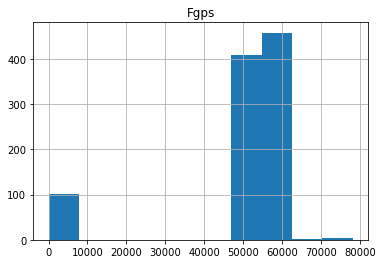

In [55]:
## Plotting the Fgps column.
import matplotlib.pyplot as plt
hist = ValidateDF.hist(column='Fgps')

Having Zero values means that there was no Swarm points into the ST-Cylinder for certains rows with specific date and time. The `DeltaTime` parameter have an important impact to determine how many points the ST-IDW process will consider. The following figure shows the difference to choose a `DeltaTime` parameter of 4 hours (14400 seconds) and 12 hours (43200 seconds).
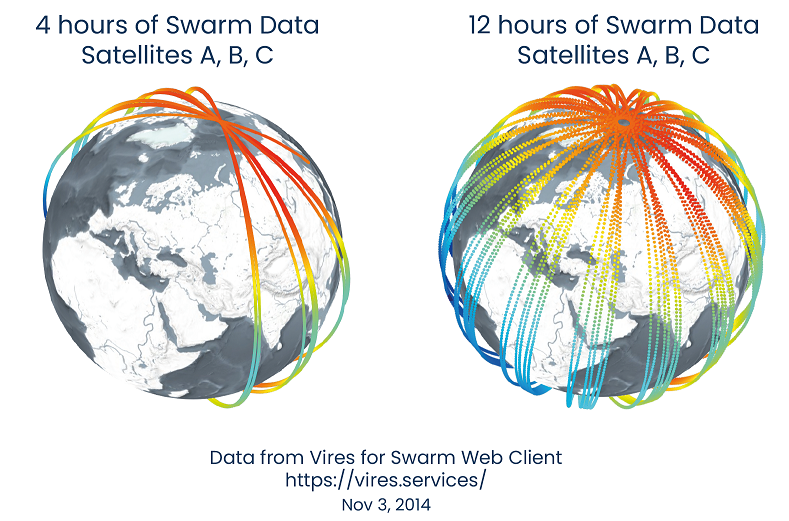

### Selecting rows with no Magnetic messures:

Despite we include the magnetic measures from the three satellites of Swarm. There are cases or locations where there is no Swarm points for the defined **Space-Time Window**. To address this issue we can change the `DeltaTime` (DT) parameter to increase the `height` of our Space-Time cylinder. In order to reach more Swarm measures we will  set a ***new delta time of 12 hours*** only for those points with issues to get the satellite data. But first we need to filter those points with no magnetic values and create another dataframe to be used as a "new" GPS track and run the annotation process again with the wider DT.

 **1**. Initially we set new dataframes for the set of point with the Column `TotalPoint` with Zero, and we create another dataframe with the remaining rows to later on combine with the result from the latest annotation process. 

In [16]:
ZeroValues = SwarmAnnotation[SwarmAnnotation.TotalPoints == 0]
NoZeroValues = SwarmAnnotation[(SwarmAnnotation[['TotalPoints']] != 0).all(axis=1)]

In [17]:
ZeroValues.head(10)

,Latitude,Longitude,DateTime,Fgps,N,E,C,H,D,I,TotalPoints,MinDist,AvDist
71,57.427383,31.894067,2014-10-01 02:42:00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,NaN,NaN
72,57.321483,31.669200,2014-10-01 02:59:00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,NaN,NaN
73,57.195767,31.446667,2014-10-01 03:14:00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,NaN,NaN
88,53.353933,19.858717,2014-10-01 14:38:00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,NaN,NaN
89,53.324533,19.568867,2014-10-01 14:54:00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,NaN,NaN
90,53.259633,18.964567,2014-10-01 15:26:00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,NaN,NaN
91,53.268217,18.664850,2014-10-01 15:42:00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,NaN,NaN
106,53.795533,16.179567,2014-10-02 03:42:00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,NaN,NaN
107,53.889767,16.161283,2014-10-02 04:14:00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,NaN,NaN
108,54.208517,15.977883,2014-10-02 05:02:00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,NaN,NaN


**2**. We need to do some formatting, removing not necessary columns, and transforming the dataframe as a new GPS track, but including only those rows where there was no magnetic measures. 

In [18]:
#Dropping some columns to transform the ZeroValues dataframe as another GPS track.
ZeroValues.drop(['Fgps','N','E','C','H','D','I','TotalPoints','MinDist','AvDist'], axis=1, inplace=True)
ZeroValues.rename(columns={"Latitude": "gpsLat", "Longitude": "gpsLong", "DateTime":"gpsDateTime"}, inplace=True)
ZeroValues['epoch'] = ZeroValues['gpsDateTime'].astype('int64')//1e9

<ipython-input-18-a25f5301a67e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZeroValues['epoch'] = ZeroValues['gpsDateTime'].astype('int64')//1e9


In [19]:
ZeroValues.head(10)

,gpsLat,gpsLong,gpsDateTime,epoch
71,57.427383,31.894067,2014-10-01 02:42:00,1.412131e+09
72,57.321483,31.669200,2014-10-01 02:59:00,1.412132e+09
73,57.195767,31.446667,2014-10-01 03:14:00,1.412133e+09
88,53.353933,19.858717,2014-10-01 14:38:00,1.412174e+09
89,53.324533,19.568867,2014-10-01 14:54:00,1.412175e+09
90,53.259633,18.964567,2014-10-01 15:26:00,1.412177e+09
91,53.268217,18.664850,2014-10-01 15:42:00,1.412178e+09
106,53.795533,16.179567,2014-10-02 03:42:00,1.412221e+09
107,53.889767,16.161283,2014-10-02 04:14:00,1.412223e+09
108,54.208517,15.977883,2014-10-02 05:02:00,1.412226e+09


### Running the ST-IDW and annotation process for the problematic rows

**1**. Now we separated in two dataframes the rows with no magnetic values and the one that were correctly compute. We can use the `ZeroValues` dataframe to run one more time the **ST-IDW process** but including a wider time window. The DeltaTime for this subset of data will be `DT = 43200`corresponding to 12 hours of data.

In [20]:
%%time
#Sequential
if __name__ == '__main__':
    DT= 43200
    dnZ = [] ## List used to add all the Zero Values GPS points with the annotated MAG Data.
    for index, row in ZeroValues.iterrows():
        GPSLat = row['gpsLat']
        GPSLong = row['gpsLong']
        GPSDateTime = row['gpsDateTime']
        GPSTime = row['epoch']
        print("Process for:", index,"Epoch:",GPSDateTime)
        result_zero=SwarmMagAnnotation(GPSLat,GPSLong,GPSDateTime,GPSTime, DT)
        dnZ.append(result_zero)

Process for: 71 Epoch: 2014-10-01 02:42:00
Process for: 72 Epoch: 2014-10-01 02:59:00
Process for: 73 Epoch: 2014-10-01 03:14:00
Process for: 88 Epoch: 2014-10-01 14:38:00
Process for: 89 Epoch: 2014-10-01 14:54:00
Process for: 90 Epoch: 2014-10-01 15:26:00
Process for: 91 Epoch: 2014-10-01 15:42:00
Process for: 106 Epoch: 2014-10-02 03:42:00
Process for: 107 Epoch: 2014-10-02 04:14:00
Process for: 108 Epoch: 2014-10-02 05:02:00
Process for: 109 Epoch: 2014-10-02 05:18:00
Process for: 141 Epoch: 2014-10-03 03:47:00
Process for: 142 Epoch: 2014-10-03 04:03:00
Process for: 143 Epoch: 2014-10-03 04:19:00
Process for: 144 Epoch: 2014-10-03 04:35:00
Process for: 165 Epoch: 2014-10-03 15:51:00
Process for: 179 Epoch: 2014-10-04 03:53:00
Process for: 180 Epoch: 2014-10-04 04:09:00
Process for: 181 Epoch: 2014-10-04 04:25:00
Process for: 182 Epoch: 2014-10-04 04:41:00
Process for: 183 Epoch: 2014-10-04 05:29:00
Process for: 201 Epoch: 2014-09-30 00:59:00
Process for: 214 Epoch: 2014-10-01 15:0

**2.** With the appended list as results from the last loop, a new dataframe is created.

In [21]:
ZeroSwarmDataset = pd.DataFrame(dnZ)
ZeroSwarmDataset.head(10)

,Latitude,Longitude,DateTime,Fgps,N,E,C,H,D,I,TotalPoints,MinDist,AvDist
0,57.427383,31.894067,2014-10-01 02:42:00,52102.884319,15444.077385,2699.635046,49688.056902,15678.251039,9.915164,72.487764,50,173.642413,844.927569
1,57.321483,31.669200,2014-10-01 02:59:00,52061.839343,15474.859340,2665.622952,49637.267234,15702.764639,9.773575,72.445217,51,188.018658,854.398465
2,57.195767,31.446667,2014-10-01 03:14:00,52017.092826,15556.354382,2642.681862,49566.057105,15779.224603,9.641250,72.341262,50,203.258382,849.222223
3,53.353933,19.858717,2014-10-01 14:38:00,49794.857074,17829.665513,1529.071515,46468.190830,17895.111958,4.901691,68.938077,38,107.478811,701.623768
4,53.324533,19.568867,2014-10-01 14:54:00,49751.815612,17861.152223,1503.119436,46410.807254,17924.288739,4.810437,68.882972,36,99.748146,667.786960
5,53.259633,18.964567,2014-10-01 15:26:00,49741.632061,17884.554474,1512.914530,46390.556809,17948.431661,4.835330,68.848626,36,95.335092,662.784781
6,53.268217,18.664850,2014-10-01 15:42:00,49744.446092,17881.372127,1517.892231,46394.638171,17945.680984,4.852023,68.853277,36,94.869787,661.181614
7,53.795533,16.179567,2014-10-02 03:42:00,49921.108624,17673.468655,1542.744708,46662.463831,17740.675172,4.988793,69.183619,44,185.067407,818.002348
8,53.889767,16.161283,2014-10-02 04:14:00,49977.374339,17580.507713,1542.652066,46757.715074,17648.060144,5.014738,69.321672,43,177.811972,807.622829
9,54.208517,15.977883,2014-10-02 05:02:00,50091.596625,17362.673188,1512.425199,46961.880310,17428.420761,4.978346,69.639180,42,162.258561,798.198321


### Integrating the final result

To finish the process we join both dataframes into a final `MagDataFinal` dataframe, including the dataframe intially processed with the original delta time value and the dataframe that was processed uisng a wider delta time value to include a bigger range of points into the space and time cylinder and run the ST-IDW process.

We will concatenate the two dataframes with the same schema and with the correct magnetic values. The entire GPS track has been annotated with the magnetic components from Swarm and computed at the ground level. The final dataframe will include the following components:

1. The **Magnetic Field Intensity** mapped as Fgps in nanoTeslas (nT).
2. The **N (Northwards) component** mapped as N in nanoTeslas (nT)
3. The **E (Eastwards) component** mapped as E. in nanoteslas (nT)
4. The **C (Downwards or Center)** component mapped as C in nanoTeslas (nT).
5. The **Horizontal component** mapped as H in nanoTeslas (nT)
6. **Magnetic Declination or dip angle** mapped as D in degrees
7. **Magnetic Inclination** mapped as I in degrees
8. **Total Points** as the amount of Swarm messuares included in the ST-IDW process from the trajectories fetched in the three satellites.
9. **Minimum Distance** mapped as MinDist, representing the minimum distance amount the set of identified point inside the Space Time cylinder and each GPS point location.
10. **Average Distance** mapped as AvDist, representing the average distance amount the set of distances between the identified Swarm Point in the Space Time cylinder and the GPS Points location.
11. **Latitude** from the GPS Track
12. **Longitude** from the GPS Track
13. **Timestamp** from the GPS Track.

The following figure can guide you through the aforementioned values and get a better perspective of the earth's magnetic field components, included in the annotation process using the **ST-IDW method.**

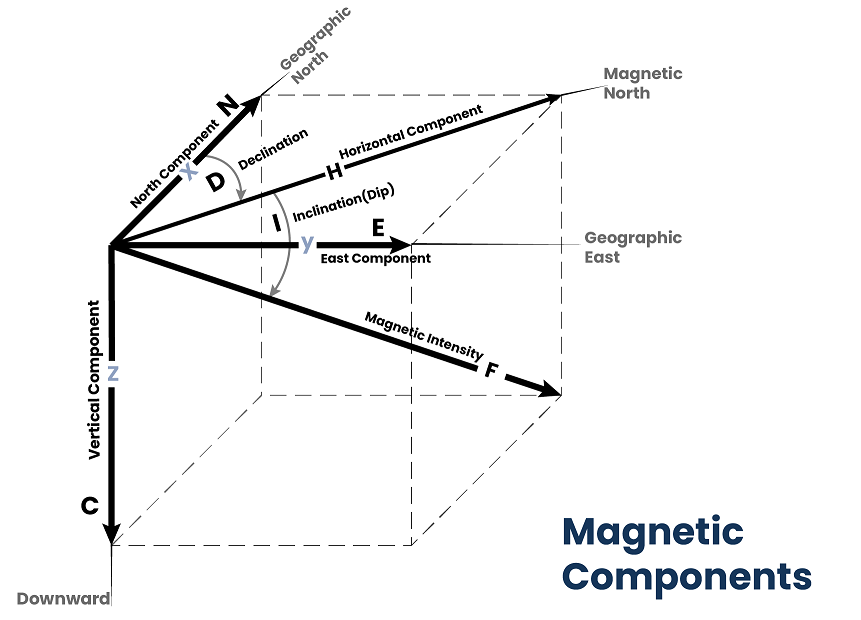

In [2]:
GeoMagResults= pd.concat([NoZeroValues, ZeroSwarmDataset])
GeoMagResults.head()

NameError: name 'pd' is not defined

### Validating the final results for new outliers
Before mapping the final results, it would be useful to validate again we did not get any outlier and all the GPS Track rows have a proper Magnetic Values.

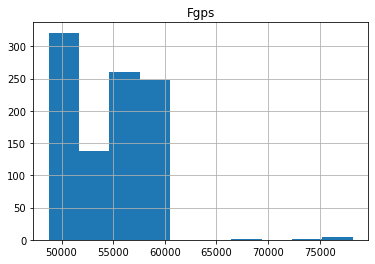

In [170]:
hist2 = GeoMagResults.hist(column='Fgps')

### Mapping the GPS Track using the annotated Magnetic Values (Optional)

Now we are going to plot the annotated GPS track stored into the MagDataFinal dataframe to see how the different magnetic components in a map to have a better prespective of the impact of the earth magnetic field.

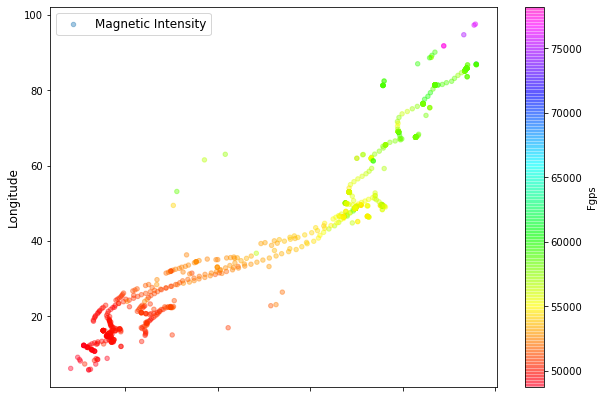

In [29]:
import matplotlib.pyplot as plt

GeoMagResults.plot(kind="scatter", x="Latitude", y="Longitude",
    label="Magnetic Intensity",
    c="Fgps", cmap=plt.get_cmap("gist_rainbow"),
    colorbar=True, alpha=0.4, figsize=(10,7)
    
)

plt.ylabel("Longitude", fontsize=12)
plt.xlabel("Latitude", fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [93]:
import geopandas
import geoplot
gdf = geopandas.GeoDataFrame(GeoMagResults, geometry=geopandas.points_from_xy(GeoMagResults.Longitude, GeoMagResults.Latitude))
gdf.head()

,Latitude,Longitude,DateTime,Fgps,N,E,C,H,D,I,TotalPoints,MinDist,AvDist,geometry
0,70.854717,68.307333,2014-09-08 05:54:00,58263.516606,6533.771524,3145.053928,57810.516628,7251.312608,25.704002,82.850591,21,327.950987,626.701218,POINT (68.30733 70.85472)
1,70.830300,67.975050,2014-09-08 06:10:00,58261.123705,6538.091436,3149.741775,57807.361318,7257.238653,25.722557,82.844422,21,340.038476,628.953831,POINT (67.97505 70.83030)
2,70.761717,67.752417,2014-09-08 06:26:00,58058.984855,6682.091934,3212.055102,57583.661501,7414.017169,25.673409,82.663410,26,348.223318,656.804069,POINT (67.75242 70.76172)
3,70.686517,67.561983,2014-09-08 06:42:00,58056.861413,6699.935204,3220.395629,57578.981212,7433.712380,25.671765,82.643543,26,355.472899,657.901776,POINT (67.56198 70.68652)
4,70.685450,67.548317,2014-09-08 07:14:00,58045.681746,6704.933680,3235.486162,57566.280608,7444.763687,25.759774,82.631119,26,355.980432,657.921513,POINT (67.54832 70.68545)


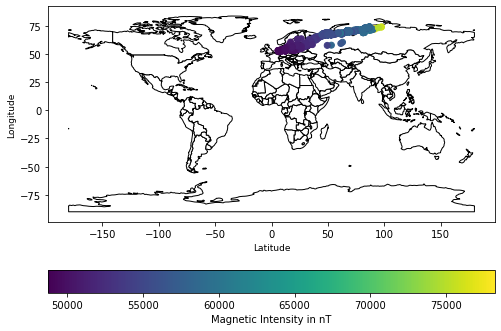

In [94]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# We restrict to South America.
ax = world.plot(color='white', edgecolor='black', figsize = (8,6))

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, column='Fgps', legend=True, 
         legend_kwds={'label': "Magnetic Intensity in nT",
                      'orientation': "horizontal"})
plt.ylabel("Longitude", fontsize=9)
plt.xlabel("Latitude", fontsize=9)

plt.show()

Text(567.7954545454544, 0.5, 'Longitude')

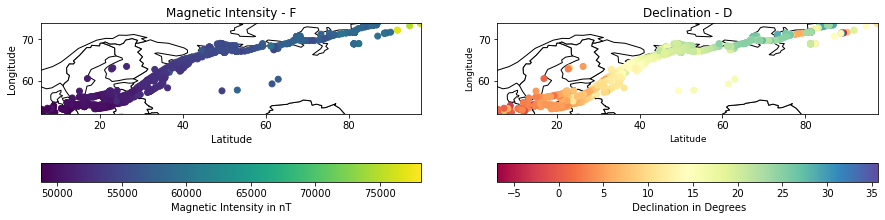

In [215]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,6))

ax1 = world.plot(ax=ax1, color='white', edgecolor='black')
xlim = ([gdf.total_bounds[0],  gdf.total_bounds[2]])
ylim = ([gdf.total_bounds[1],  gdf.total_bounds[3]])
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)


gdf.plot(ax=ax1, column='Fgps', legend=True,
         legend_kwds={'label': "Magnetic Intensity in nT",
                      'orientation': "horizontal"})
plt.ylabel("Longitude", fontsize=9)
plt.xlabel("Latitude", fontsize=9)
ax1.set_title('Magnetic Intensity - F')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitude')


ax2 = world.plot( ax=ax2, color='white', edgecolor='black')
xlim = ([gdf.total_bounds[0],  gdf.total_bounds[2]])
ylim = ([gdf.total_bounds[1],  gdf.total_bounds[3]])
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)


# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax2, column='D', legend=True, cmap='Spectral', 
         legend_kwds={'label': " Declination in Degrees",
                      'orientation': "horizontal"})
ax2.set_title('Declination - D')
ax2.set_xlabel('Latitude')
ax2.set_ylabel('Longitude')

### Exporting the annotated DF into a CSV file (Optional)

In [ ]:
#Exporting the CSV file
os.chdir('C:\\foss4guk19-jupyter-master\\Project_StAndrews\\VirES\\results')
outputfile ="GeoMag_"+gpsfilename
export_csv = MagDataFinal.to_csv (outputfile, index = None, header=True)

## Parallel Mode <a class="anchor" id="Parallel"></a>

**MagGeo** is available in parallel mode in order to process a considerable big dataset or gps tracks with millions of points than need to be annotated with the magnetic values. Taking the full advantage of your CPU capacity, the parallel mode will use the `multiprocessing` module from python(check the minimum requirements for **MagGeo**).

### Initial considerations

For parallel processing, there are some considerations to make:

1. Linux and Windows environments have some differences. In windows we need to separate the functions and store them separately, then import them into a `main` function. 
3. Defining what part of the process is CPU bound and what part is I/O bound: Identify what parts of the program are I/O bound (writing or reading from the disk or network) and what part par CPU bound ( Processing capacity). To take advantage of our CPU capacity we need to identify the process where the CPU is actually doing the main Tasks. Those are the functions and the processes we will parallelize. 

>🔈**Note** 🔈: Overall we could split **MagGeo** into two parts. The initial part is about to fetching the data and getting the residuals from the CHAOS model, this part is the most important part as we are gathering the data we need based on the GPS track date and times values. The second part is the interpolation **ST-IDW** and the annotation process where MagGeo is actually returning a new table or python dataframe with the magnetic values for each GPS date and time.

The initial part [4.13 section] is mostly I/O bound, as we have to download the data from Swarm Client and then compute the residuals to compute the Magnetic values at the ground level. Perhaps we might want to parallelize also this section, although due to this task is mainly getting the data from a external server it does not make too much sense dedicate several cores of CPU capacity for the same broadband capacity. Instead,  we are going to store the `TotalSwarmData_A`,`TotalSwarmData_B` and `TotalSwarmData_C` pandas dataframes into csv files to be manipulated into a set of individuals functions. The parallel processing requires working with no intermediary results along the functions, so we need to guarantee that all the functions will have the parameters they need once they are invocated.

### Importing the requeried libraries

In [133]:
from viresclient import SwarmRequest
from viresclient import ClientConfig
import datetime as dt
import sys,os
from pathlib import Path
import pandas as pd
import numpy as np
import datetime, time
from datetime import timedelta
import math
import pathlib
from datetime import datetime
import time
import calendar
import datetime

import multiprocessing
import sklearn
from multiprocessing import Pool

### Reading the GPS track
The following steps will load the GPS track from a csv file, and set some requirements before download the data from Swarm.

Importing the GPS track. You can note that there is a folder to store the CSV file. Using `os.getcwd()` you can validate where the file is located.

In [ ]:
gpsfilename="Data4Paper_915.csv"
def getGPSData():
    os.chdir("C:\\foss4guk19-jupyter-master\\Project_StAndrews\\VirES\\TestData")
    nfp = pd.read_csv(gpsfilename, parse_dates=[0], encoding='utf-8', dayfirst=True)
    gpsData = pd.DataFrame({'gpsLat':nfp['location-lat'], 'gpsLong': nfp['location-long'], 'gpsDateTime':nfp['timestamp']})
    return gpsData

In [ ]:
# Calling the previous function to get the track as Dataframe.
GPSData = getGPSData()
GPSData.head()

### Date and time formatting 

Setting the date and time attributes for the requerided format and computing the epoch column. Values like Maximum and Minimun Date and time are also calculated.

In [ ]:
#3.1 Convert the gpsDateTime to datetime python object
GPSData['gpsDateTime'] = pd.to_datetime(GPSData['gpsDateTime'], format='%d/%m/%Y %H:%M')
GPSData['gpsDateTime'] = GPSData['gpsDateTime'].map(lambda x: x.replace(second=0))
GPSData['gpsLat'] = GPSData['gpsLat'].astype(float)
#3.2 Adding new column epoch, will be usefuel to compare the date&time o each gps point againts the gathered swmarm data points
GPSData['epoch'] = GPSData['gpsDateTime'].astype('int64')//1e9
GPSData['epoch'] = GPSData['epoch'].astype(int)
#3.3 Computing Date and Time columns
GPSData['dates'] = GPSData['gpsDateTime'].dt.date
GPSData['times'] = GPSData['gpsDateTime'].dt.time
#3.4 Maximum and Minimum values
MinDateTime = min(GPSData['gpsDateTime'])
MaxDateTime = max(GPSData['gpsDateTime'])
dt_object1 = MinDateTime.to_pydatetime()
dt_object2 = MaxDateTime.to_pydatetime()
startDate = MinDateTime.date()
endDate = MaxDateTime.date()
MinTime=MinDateTime.time()
MaxTime=MaxDateTime.time()

In [ ]:
GPSData.head()

### Validating the proper amount of Swarm messures
The annotation process apply an interpolation process which require for each GPS point time a set of Swarm points in the range of at least 4 hours before and 4 hours after each GPS Point time. To guarantee that all the GPS points have the enough amount of satellites measures.

**1**. The following loop is identifiying the time and validating if the time is less than 4:00 hours and more than 20:00 hours to bring one extra day of data. The result of this validation is written in a empty python list which will be later validated to get the unique dates avoing to download data for the same day and reducing the the downloand time process.

In [ ]:
datestimeslist = []
for index, row in GPSData.iterrows():
    datetimerow  = row['gpsDateTime']
    daterow = row['dates']
    hourrow = row['times']
    hourrow = hourrow.strftime('%H:%M:%S')
    if hourrow < '04:00:00':
        date_bfr = daterow - (timedelta(days=1))
        datestimeslist.append(daterow)
        datestimeslist.append(date_bfr)
    if hourrow > '20:00:00':
        Date_aft = daterow + (timedelta(days=1))
        datestimeslist.append(daterow)
        datestimeslist.append(Date_aft)  
    else:
        datestimeslist.append(daterow)

**2.** Getting a list of unique dates, to being used to download the Swarm Data

In [ ]:
def uniquelistdates(list): 
    x = np.array(list) 
    uniquelist = np.unique(x)
    return uniquelist

uniquelist_dates = uniquelistdates(datestimeslist)
uniquelist_dates

### Fetching the data from Swarm and computing them at the ground level:  <a class="anchor" id="Fetching"></a>

Once the date and time columns have been defined, and the unique dates were identified the script can start the download process. Usually the data from Swarm is requested using only one satellite, however **MagGeo** will use the magnetic measures from the three satellite of the Swarm Mission. The following function (`GetSwarmData_and_residual`) is  mainly divided in two parts. Get the data from Swarm including the residuals and then compute the magnetic field at the ground level using the residuals from the CHAOS model. 

> **🔎 CHAOS** is a comprehensive field model, containing the modelled contributions of the time-varying core, the static crustal field, the average time-varying magnetosphere. We show calculation of the residuals (adding this parameter `residuals=True`) which means: data - *CHAOS(Core+Static)* and  data -*CHAOS(Core+Static+Magnetosphere)*.

The **CHAOS** model is available on the server as model variables:

- CHAOS-Core: SH degree 1-20
- CHAOS-Static: SH degree 21-110
- CHAOS-MMA-Primary: Magnetosphere external field, SH degree 1-2
- CHAOS-MMA-Secondary: Magnetosphere internal induced field, SH degree 1-2

We will use the abbreviations:

- MCO: core model
- MLI: lithosphere model (i.e. static)
- MMA: magnetosphere model

This will compute the magnetic measures not at the height of the three satellites ( 450 km and 550 km above the sea level) and will approximate calculate the Swarm measures at the ground level, making the measures more precise to any GPS trajectory.

**1.** Defining `GetSwarmData_and_residuals`fucntion to fetch Swarm data and compute the magnetic values at the ground level.

In [ ]:
%%time
import chaosmagpy as cp
from chaosmagpy import load_CHAOS_matfile
from chaosmagpy.data_utils import mjd2000

def GetSwarmData_and_residuals (startDateTime, endDateTime, mid_date):
    
    # 1. Starting the Swarm Request.
    #    `SwarmRequest` is an object provided by the VirES interface, we need time objects 
    #    to be used by `SwarmRequest.get_between()` in this case we will fetch every date one day per loop (i.e. around 15 orbits)
    #    of the scalar (`F`) measurements from Swarm Satellites. The data are then loaded as a `xarray` dataframe.
    #    donwsamples the data to 60 seconds, from the `MAGx_LR` product having default of 1 second.
    #    https://viresclient.readthedocs.io/en/latest/available_parameters.html
    
    requestA = SwarmRequest() 
    requestB = SwarmRequest()
    requestC = SwarmRequest()
    
    #2. Loading the matlab CHAOS model to compute the residuals and resting those values from the residuals from Swarm.
    model = load_CHAOS_matfile('C:\\foss4guk19-jupyter-master\\Project_StAndrews\\Parallel\\CHAOS-7.mat') 
    #For more information about the magnetic models go to: https://www.space.dtu.dk/english/research/scientific_data_and_models/magnetic_field_models
    
    #3. Getting the data for Satellite A. 
    requestA.set_collection("SW_OPER_MAGA_LR_1B")
    requestA.set_products(
        measurements=[
            'B_NEC', #The Magnetic values are in NEC system (North, East, Centre)

        ],

        models = [
            '"CHAOS_MCO_MLI" = "CHAOS-Core" + "CHAOS-Static"',
            '"CHAOS_MCO_MLI_MMA" = "CHAOS-Core" + "CHAOS-Static" + "CHAOS-MMA-Primary" + "CHAOS-MMA-Secondary"'
        ],
        residuals=True, #Brining the residuals.
        sampling_step="PT60S", #Get the data every 60 seconds. 
    )
    
    #4. Defining an array to store the data request for Satellite A, based on the starting Data and time.
    #   You can display dsA to get an idea of how the data is requested.
    dsA = requestA.get_between(
        start_time=startDateTime,
        end_time=endDateTime
    ).as_xarray()
    
    
    #5. Brining the residuals from CHAOS Model, the one was loaded in step No 2.
    
    thetaA = 90-dsA["Latitude"].values  # colatitude in degrees (colatitude = 90-latitude)
    phiA = dsA["Longitude"].values  # longitude in degrees
    time = mjd2000(mid_date.year, mid_date.month, mid_date.day)  * np.ones((thetaA.size,)) # The core field does not change over a day so pick a single time
    radius = 6371.2 * np.ones((thetaA.size,))
    # this is the Earth's average radius - 
    # if you need to add the heigth of your GPS trajectory, you need to put in the bird's height in km above the centre of the Earth
    # and parsing this values as one extra parameter of this fuction. 
   
    #6. The residuals from the model CHAOS are computed.  
    B_r_coreA, B_t_coreA, B_phi_coreA = model.synth_values_tdep(time,radius, thetaA, phiA)
    B_r_crustA, B_t_crustA, B_phi_crustA = model.synth_values_static(radius, thetaA, phiA)
    
    #7. Once the xarray is created, we can extracted the variables included using xarray.DataArray object e.g. dsA["Latitude"]).
    # The SwarmRequest inside in the dsA xarray has Timestamp as index. The vector measurements have 3 dimensions which are 
    # the three components (N, E, C). One dimension can be extracted like indexing into a numpy ndarray. The N (Northwards)
    # component is accessed as xarray["variable"][:, index]:
    
    B_r_swarmA, B_t_swarmA, B_phi_swarmA = -dsA["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 2], -dsA["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 0], dsA["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 1]
   
    #8. Once the residuals are computed and extracted for Swarm data stored temporaly in xarray. The Magnetic fiel on
    #   the ground is computed.
    B_r_groundA = B_r_coreA + B_r_crustA - B_r_swarmA #(-Z)
    B_t_groundA = B_t_coreA + B_t_crustA - B_t_swarmA #(-X)
    B_phi_groundA = B_phi_coreA + B_phi_crustA - B_phi_swarmA #(Y)
    
    #9. Due to Swarm data are in NEC (or XYZ) while the CHAOS model outputs the radial, theta and phi components which are Br = -Z, 
    #   Bt = -X and BP = Y
    C_groundA = -B_r_groundA   #Z
    N_groundA = -B_t_groundA   #X
    E_groundA = B_phi_groundA  #Z
    
    #10. To finish the transformation and extraction process, a final dataframe is created, setting clear names and including
    #    a epoch columns to be the dataframe index.
    
    SwarmDataA = pd.DataFrame({'Na':N_groundA,'Ea':E_groundA, 'Ca':C_groundA, 'Ta':N_groundA['Timestamp'], 'LatA':dsA['Latitude'], 'LongA':dsA['Longitude']})
    SwarmDataA['epoch'] = SwarmDataA['Ta'].astype('int64')//1e9
    SwarmDataA['epoch'] = SwarmDataA['epoch'].astype(int)
    SwarmDataA.set_index("epoch", inplace=True)
    
    #11. The same process will take place for the satellites Bravo and Charlie.
    
    ######Request for Sat B #########
    requestB.set_collection("SW_OPER_MAGB_LR_1B")
    requestB.set_products(
        measurements=[
            'B_NEC',

        ],
        models = [
            '"CHAOS_MCO_MLI" = "CHAOS-Core" + "CHAOS-Static"',
            '"CHAOS_MCO_MLI_MMA" = "CHAOS-Core" + "CHAOS-Static" + "CHAOS-MMA-Primary" + "CHAOS-MMA-Secondary"'
        ],
        residuals=True, 
        sampling_step="PT60S",
    )

    dsB = requestB.get_between(
        start_time= startDateTime,
        end_time= endDateTime
    ).as_xarray()
    
    # Getting the residuals for SatB...
    thetaB = 90-dsB["Latitude"].values  # colatitude in degrees (colatitude = 90-latitude)
    phiB = dsB["Longitude"].values  # longitude in degrees
    time = mjd2000(mid_date.year, mid_date.month, mid_date.day)  * np.ones((thetaB.size,))
    radius = 6371.2 * np.ones((thetaB.size,))  
    B_r_coreB, B_t_coreB, B_phi_coreB = model.synth_values_tdep(time,radius, thetaB, phiB)
    B_r_crustB, B_t_crustB, B_phi_crustB = model.synth_values_static(radius, thetaB, phiB)
    
    B_r_swarmB, B_t_swarmB, B_phi_swarmB = -dsB["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 2], -dsB["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 0], dsB["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 1]


    B_r_groundB = B_r_coreB + B_r_crustB - B_r_swarmB #(-Z)
    B_t_groundB = B_t_coreB + B_t_crustB - B_t_swarmB #(-X)
    B_phi_groundB = B_phi_coreB + B_phi_crustB - B_phi_swarmB #(Y)
    
    C_groundB = -B_r_groundB   #Z
    N_groundB = -B_t_groundB   #X
    E_groundB = B_phi_groundB  #Y
    
    SwarmDataB = pd.DataFrame({'Nb':N_groundB,'Eb':E_groundB, 'Cb':C_groundB, 'Tb':N_groundB['Timestamp'], 'LatB':dsB['Latitude'], 'LongB':dsB['Longitude']})
    SwarmDataB['epoch'] = SwarmDataB['Tb'].astype('int64')//1e9
    SwarmDataB['epoch'] = SwarmDataB['epoch'].astype(int)
    SwarmDataB.set_index("epoch", inplace=True)
  
    ######Request for Sat C #########
    requestC.set_collection("SW_OPER_MAGC_LR_1B")
    requestC.set_products(
        measurements=[
            'B_NEC',

        ],
        models = [
            '"CHAOS_MCO_MLI" = "CHAOS-Core" + "CHAOS-Static"',
            '"CHAOS_MCO_MLI_MMA" = "CHAOS-Core" + "CHAOS-Static" + "CHAOS-MMA-Primary" + "CHAOS-MMA-Secondary"'
        ],
        residuals=True,
        sampling_step="PT60S",
    )

    dsC = requestC.get_between(
        start_time=startDateTime,
        end_time=endDateTime
    ).as_xarray()
    
    #Getting the residuals for SatC...
    thetaC = 90-dsC["Latitude"].values  # colatitude in degrees (colatitude = 90-latitude)
    phiC = dsC["Longitude"].values  # longitude in degrees
    time = mjd2000(mid_date.year, mid_date.month, mid_date.day)  * np.ones((thetaC.size,))
    radius = 6371.2 * np.ones((thetaC.size,)) 

    B_r_coreC, B_t_coreC, B_phi_coreC = model.synth_values_tdep(time,radius, thetaC, phiC)
    B_r_crustC, B_t_crustC, B_phi_crustC = model.synth_values_static(radius, thetaC, phiC)
    
    B_r_swarmC, B_t_swarmC, B_phi_swarmC = -dsC["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 2], -dsC["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 0], dsC["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 1]

    B_r_groundC = B_r_coreC+ B_r_crustC - B_r_swarmC #(-Z)
    B_t_groundC = B_t_coreC + B_t_crustC - B_t_swarmC #(-X)
    B_phi_groundC = B_phi_coreC + B_phi_crustC - B_phi_swarmC #(Y)
    
    C_groundC = -B_r_groundC   #Z
    N_groundC = -B_t_groundC   #X
    E_groundC = B_phi_groundC  #Y
    
    SwarmDataC = pd.DataFrame({'Nc':N_groundC,'Ec':E_groundC, 'Cc':C_groundC, 'Tc':N_groundC['Timestamp'], 'LatC':dsC['Latitude'], 'LongC':dsC['Longitude']})
    SwarmDataC['epoch'] = SwarmDataC['Tc'].astype('int64')//1e9
    SwarmDataC['epoch'] = SwarmDataC['epoch'].astype(int)
    SwarmDataC.set_index("epoch", inplace=True)
    
    return SwarmDataA,SwarmDataB,SwarmDataC

**2.** Running the previous function, using a loop to going through every date in the unique date list. The **Vires client API**, requires a token. You can visit https://vires.services/ to get your own token. We highly recommend to use your own token to run the script to annotate your own GPS tracks. As we mentioned in the previous function definition the `SwarmRequest()` object have the `get_between` parameter which require a datetime variables. As the unique list is just a date python variable, we set a range of **24 hours to fetch the data** for one entire day at the every iteration. 

> 🔈 **Note:** 🔈 If you are aware that rather to fetching each day in the unique list we might set a minimum and maximum dates for the GPS track dates and thus fetch the whole data at once. Unfortunately due to the calculations required to compute the residual from the **local CHAOS model**, the number of days is limited to 10 days, including more days will raise a error into the `chaosmagpy` package. Likewise the amount of processing and downloading time is certainly very similar to fetch each date into a loop iteration. Therefore we have choose the most secure option.

> ⏳ **Be aware:** Due to the amount of dates the GPS track has (40 days) to fetch and compute the residuals, the time to process the sample data will take **approximately 20 minutes.**

In [ ]:
%%time

hours_t_day = 24
hours_added = datetime.timedelta(hours = hours_t_day)

listdfa = []
listdfb = []
listdfc = []

cc = ClientConfig()
cc.set_site_config("https://vires.services/ows", token="rp-foC8gz-VTFz7He6SMPnQtKEpasEaB")
cc.default_url = "https://vires.services/ows"
cc.save()

for d in uniquelist_dates:
    print("Process for:",d,":" )
    startdate = datetime.datetime.combine(d, datetime.datetime.min.time())
    enddate = startdate + hours_added
    mid_date = d
    SwarmDataA,SwarmDataB,SwarmDataC = GetSwarmData_and_residuals(startdate, enddate,mid_date)
    listdfa.append(SwarmDataA)
    listdfb.append(SwarmDataB)
    listdfc.append(SwarmDataC)

**3.**  As you might noted in the previous cell we append the results from each iteration into a empty python list. In here we join a sequence of arrays along the 0 axis (by applying the `concant` function ), to get a pandas dataframe that contains the data for each Swarm satellite for all the unique dates we identified in the GPS track `datetime` column.

In [ ]:
TotalSwarm_A = pd.concat(listdfa, join='outer', axis=0)
TotalSwarm_B = pd.concat(listdfb, join='outer', axis=0)
TotalSwarm_C = pd.concat(listdfc, join='outer', axis=0)
TotalSwarm_A

### Writting the fetched data in Disk, to be used into the requeried functions
In Parallel mode we can not use a temporary results, therefore we need to store in disk the previous pandas dataframes in csv files.

In [ ]:
####Removing all previous files(.csv) to guarantee the script will use only the recent ones.
SwarmDir= 'C:\\foss4guk19-jupyter-master\\Project_StAndrews\\VirES\\Parallel'
filelist = [ f for f in os.listdir(SwarmDir) if f.endswith(".csv") ]
for f in filelist:
    os.remove(os.path.join(SwarmDir, f))

    
TotalSwarm_A.to_csv ('SwarmDataA.csv', header=True)
TotalSwarm_B.to_csv ('SwarmDataB.csv', header=True)
TotalSwarm_C.to_csv ('SwarmDataC.csv', header=True)

### Setting number of processes, and splitting the dataframe (GPSData) in chunks

We can set the number or processess we need to dedicate for the multiprocessing mode, of course that also depends on the number of cores the machine you are using to run **MagGeo**. You can use `multiprocessing.cpu_count()` to set the number of processes as the the number of cores your machine has. Beside that we will also to split the GPS track into chucks to dedicate each core for each chuck.

In [135]:
NumCores = multiprocessing.cpu_count()
df_chunks = np.array_split(GPSData,NumCores)

In [136]:
df_chunks

[       gpsLat    gpsLong         gpsDateTime       epoch       dates     times
 0   70.854717  68.307333 2014-09-08 05:54:00  1410155640  2014-09-08  05:54:00
 1   70.830300  67.975050 2014-09-08 06:10:00  1410156600  2014-09-08  06:10:00
 2   70.761717  67.752417 2014-09-08 06:26:00  1410157560  2014-09-08  06:26:00
 3   70.686517  67.561983 2014-09-08 06:42:00  1410158520  2014-09-08  06:42:00
 4   70.685450  67.548317 2014-09-08 07:14:00  1410160440  2014-09-08  07:14:00
 ..        ...        ...                 ...         ...         ...       ...
 77  55.628233  27.264867 2014-10-01 07:23:00  1412148180  2014-10-01  07:23:00
 78  55.513917  26.967033 2014-10-01 07:40:00  1412149200  2014-10-01  07:40:00
 79  55.396383  26.703400 2014-10-01 07:56:00  1412150160  2014-10-01  07:56:00
 80  53.929300  22.913617 2014-10-01 11:42:00  1412163720  2014-10-01  11:42:00
 81  53.795100  22.347700 2014-10-01 12:13:00  1412165580  2014-10-01  12:13:00
 
 [82 rows x 6 columns],
         gpsLa

### Running the process in parallel mode

Although the next cell seems running a small `main` function.  What is happening is a call for several functions running at same time for several cores. Initially we set a pool of processes. Using the `pool` class we will distribute the assigned function among the data chucks we created. Every data chunk will be like a subset of the entire GPS track. So we need to iterate among data chunk. And inside every data chunk we need to identify the `datetime`, `epoch`, `latitude` and `longitude` of each row to run the interpolation & annotation process using the Swarm data we have filtered and stored in the previous steps.

The function will be in charge to distribute the required function (`row_handler`) among the data chunks is the map function from the `pool` class. 

row_handler.py is a  interows iteration to get the required parameter for the `SwarmMagAnnotation` function. 

Inside `SwarmMagAnnotation`, we have read the Swarm Data was already filtered, and then we import  `DfTime_func`,  `distance_to_GPS`, `Kradius` , `DistJ` functions (described bellow) to compute the spatial-time cylinder and the annotation process. The return of this function is a row ( dictionary) that will be appended into a python list where all the results from the different cores. The python list from every process is concatenated into a pandas dataframe in the `main` function having there the whole chain of the parallel process.

**1. distance_to_GPS** function: Is the function in charge to calculate the distance between each GPS Point and the Swarm Point.

**2. Kradius** function: Is the function in charge to compute the R (radius) value in the cylinder. The R value will be considered based on the latitude of each GPS Point. See the figure No XX.

**3. DistJ** function: This function will calculate the `d` value as the hypotenuse created in the triangle created amount the locations of the GPS point, the location of the Swarm points and the radius value. 

**4. DfTime_func** function: This is a time function to selected the points in the range of a the Delta Time -DT window. The Delta time window has been set as 4 hours for each satellite trajectory.

There is one additional parameter into the parallel process. `DeltaTime` (DT) is the parameter we can setup to define how many Swarm we will include into the time window of the space-time cylinder. The default configuration is `DT = 14400` or 4 hours which we estimated to be the period where we can have the three satellites going along for the same point on earth.

In [152]:
%%time
from functools import partial
import row_handler

if __name__ == '__main__':
    with multiprocessing.Pool(NumCores) as pool:
        GeoMagParallelResult = pd.concat(pool.map(partial(row_handler.row_handler, DT=14400), df_chunks), ignore_index=True)

Wall time: 11.2 s


With the Parallel mode the Annotation process takes about 12 seconds to complete ( We had tested the parallel process in a  windows server machine with 12 cores, see the image bellow). With the same GPS track in the sequetial mode the process is complete in about 2 minutes. In the image bellow you can see how the machine create several python processes and all cores (full CPU capacity) is taken.

>🔈**Note**🔈: *Multiprocessing* is even  more powerfull when you have to process a big amount of data e.g 2 millons of points. Although here is making a notable improvement if you have to process a big dataset the parallelization makes even more sense.

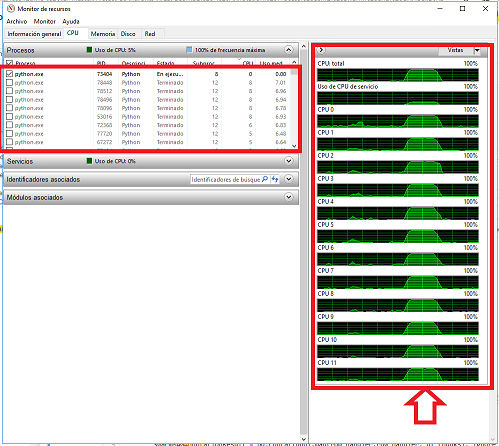

In [156]:
GeoMagParallelResult

,Latitude,Longitude,DateTime,Fgps,N,E,C,H,D,I,TotalPoints,MinDist,AvDist
0,70.854717,68.307333,2014-09-08 05:54:00,58263.516606,6533.771524,3145.053928,57810.516628,7251.312608,0.448619,1.446016,21,327.950987,626.701218
1,70.830300,67.975050,2014-09-08 06:10:00,58261.123705,6538.091436,3149.741775,57807.361318,7257.238653,0.448943,1.445908,21,340.038476,628.953831
2,70.761717,67.752417,2014-09-08 06:26:00,58058.984855,6682.091934,3212.055102,57583.661501,7414.017169,0.448086,1.442749,26,348.223318,656.804069
3,70.686517,67.561983,2014-09-08 06:42:00,58056.861413,6699.935204,3220.395629,57578.981212,7433.712380,0.448057,1.442402,26,355.472899,657.901776
4,70.685450,67.548317,2014-09-08 07:14:00,58045.681746,6704.933680,3235.486162,57566.280608,7444.763687,0.449593,1.442185,26,355.980432,657.921513
...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,55.214750,22.509733,2014-10-01 10:37:00,50407.843677,16789.678490,1554.843005,47504.103650,16861.519522,0.092344,1.229720,23,265.313281,833.224689
969,53.392167,7.292517,2014-10-03 11:28:00,49142.332711,18120.903501,173.376756,45679.006788,18121.732897,0.009567,1.193122,20,100.997905,756.182851
970,53.107067,5.922067,2014-10-04 07:11:00,49338.181544,18020.107391,936.828682,45920.085363,18044.442866,0.051941,1.196380,12,371.831436,782.732820
971,53.014967,5.811383,2014-10-04 14:12:00,49058.719497,18075.897353,-513.716457,45604.341778,18083.195782,-0.028412,1.193290,10,230.627791,870.435402


### Validating the results

To validate the results we plot the `Fgps`column. You will note that there is an significat outlier with Magnetic Intensity values with Zero.

In [1]:
## Creating a copy of the results and setting the Datetime Column as dataframe index.
ValidateDF = GeoMagParallelResult.copy()
ValidateDF.set_index("DateTime", inplace=True)

NameError: name 'GeoMagParallelResult' is not defined

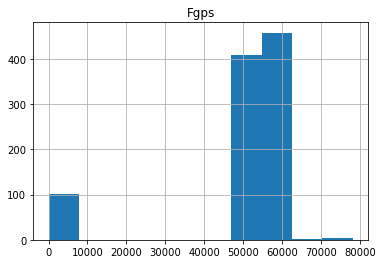

In [155]:
## Plotting the Fgps column.
import matplotlib.pyplot as plt
hist = ValidateDF.hist(column='Fgps')

Having Zero values means that there was no Swarm points into the ST-Cylinder for certains rows with specific date and time. The `DeltaTime` parameter have an important impact to determine how many points the ST-IDW process will consider. The following figure shows the difference to choose a `DeltaTime` parameter of 4 hours (14400 seconds) and 12 hours (43200 seconds).

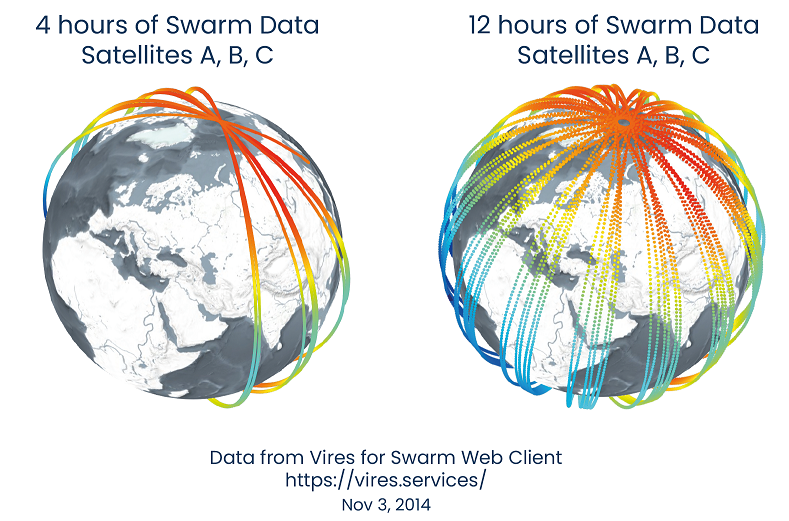

### Selecting rows with no Magnetic messures

Despite we include the magnetic measures from the three satellites of Swarm. There are cases or locations where there is no Swarm points for the defined **Space-Time Window**. To address this issue we can change the `DeltaTime` (DT) parameter to increase the "height" of our Space-Time cylinder. In order to reach more Swarm measures we will  set a ***new deltatime of 12 hours*** only for those points with issues to get the satellite data. But first we need to filter those points with no magnetic values and create another pandas dataframe to be used as a "new" GPS track and run the interpolation & annotation process again with the new DT.

**1**. Initially we set new dataframes for the set of point with the Column `TotalPoint` with Zero, and we create another pandas dataframe with the remaining rows to later on combine with the result from the latest annotation process.

In [158]:
ZeroValues = GeoMagParallelResult[GeoMagParallelResult.TotalPoints == 0]
NoZeroValues = GeoMagParallelResult[(GeoMagParallelResult[['TotalPoints']] != 0).all(axis=1)]
NoZeroValues.head(10)

,Latitude,Longitude,DateTime,Fgps,N,E,C,H,D,I,TotalPoints,MinDist,AvDist
0,70.854717,68.307333,2014-09-08 05:54:00,58263.516606,6533.771524,3145.053928,57810.516628,7251.312608,0.448619,1.446016,21,327.950987,626.701218
1,70.830300,67.975050,2014-09-08 06:10:00,58261.123705,6538.091436,3149.741775,57807.361318,7257.238653,0.448943,1.445908,21,340.038476,628.953831
2,70.761717,67.752417,2014-09-08 06:26:00,58058.984855,6682.091934,3212.055102,57583.661501,7414.017169,0.448086,1.442749,26,348.223318,656.804069
3,70.686517,67.561983,2014-09-08 06:42:00,58056.861413,6699.935204,3220.395629,57578.981212,7433.712380,0.448057,1.442402,26,355.472899,657.901776
4,70.685450,67.548317,2014-09-08 07:14:00,58045.681746,6704.933680,3235.486162,57566.280608,7444.763687,0.449593,1.442185,26,355.980432,657.921513
5,70.685750,67.549433,2014-09-08 07:30:00,58025.343330,6715.628143,3249.373034,57543.743205,7460.434738,0.450646,1.441867,26,355.937927,657.916808
6,70.690333,67.530983,2014-09-08 07:46:00,57990.038391,6733.573966,3269.069234,57504.927793,7485.174147,0.451971,1.441358,26,356.593532,657.856468
7,70.692683,67.506233,2014-09-08 08:03:00,57936.413695,6762.515584,3296.360226,57445.891272,7523.138160,0.453554,1.440577,26,357.491672,657.831026
8,70.692533,67.506167,2014-09-08 08:34:00,57803.666217,6836.087914,3357.377373,57299.736015,7616.041018,0.456523,1.438655,26,357.494814,657.833213
9,70.692583,67.506383,2014-09-08 08:50:00,57718.201582,6883.306232,3391.968293,57205.816490,7673.679273,0.457856,1.437451,26,357.486638,657.832415


**2**. We need to do some formatting, removing not necessary columns, and transforming the pandas dataframe as a "new" GPS track, but including only those rows where there was no magnetic measures.

In [159]:
ZeroValues.drop(['Fgps','N','E','C','H','D','I','TotalPoints','MinDist','AvDist'], axis=1, inplace=True)
ZeroValues.rename(columns={"Latitude": "gpsLat", "Longitude": "gpsLong", "DateTime":"gpsDateTime"}, inplace=True)
ZeroValues['epoch'] = ZeroValues['gpsDateTime'].astype('int64')//1e9

<ipython-input-159-4397cc8ebff6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZeroValues['epoch'] = ZeroValues['gpsDateTime'].astype('int64')//1e9


In [163]:
ZeroValues

,gpsLat,gpsLong,gpsDateTime,epoch
71,57.427383,31.894067,2014-10-01 02:42:00,1.412131e+09
72,57.321483,31.669200,2014-10-01 02:59:00,1.412132e+09
73,57.195767,31.446667,2014-10-01 03:14:00,1.412133e+09
88,53.353933,19.858717,2014-10-01 14:38:00,1.412174e+09
89,53.324533,19.568867,2014-10-01 14:54:00,1.412175e+09
...,...,...,...,...
930,56.149062,18.176637,2014-10-24 02:00:00,1.414116e+09
931,56.153519,18.174781,2014-10-24 02:30:00,1.414118e+09
932,56.158215,18.171885,2014-10-24 03:00:00,1.414120e+09
963,55.874354,13.298577,2014-10-23 13:30:00,1.414071e+09


### Running the ST-IDW and annotation process for the problematic rows

**1**. Now we separated in two dataframes the rows with no magnetic values and the one that were correctly compute. We can use the `ZeroValues` dataframe to run one more time the **ST-IDW process** but including a wider time window. The DeltaTime for this subset of data will be `DT = 43200`corresponding to 12 hours of data.

**2**. Before to run the annotation process, we need to define a new dataframe chunks based on the number of cores.

In [164]:
df_chunks_z = np.array_split(ZeroValues,NumCores)
df_chunks_z

[        gpsLat    gpsLong         gpsDateTime         epoch
 71   57.427383  31.894067 2014-10-01 02:42:00  1.412131e+09
 72   57.321483  31.669200 2014-10-01 02:59:00  1.412132e+09
 73   57.195767  31.446667 2014-10-01 03:14:00  1.412133e+09
 88   53.353933  19.858717 2014-10-01 14:38:00  1.412174e+09
 89   53.324533  19.568867 2014-10-01 14:54:00  1.412175e+09
 90   53.259633  18.964567 2014-10-01 15:26:00  1.412177e+09
 91   53.268217  18.664850 2014-10-01 15:42:00  1.412178e+09
 106  53.795533  16.179567 2014-10-02 03:42:00  1.412221e+09
 107  53.889767  16.161283 2014-10-02 04:14:00  1.412223e+09,
         gpsLat    gpsLong         gpsDateTime         epoch
 108  54.208517  15.977883 2014-10-02 05:02:00  1.412226e+09
 109  54.210117  15.791683 2014-10-02 05:18:00  1.412227e+09
 141  54.146717  15.093983 2014-10-03 03:47:00  1.412308e+09
 142  54.147683  15.095067 2014-10-03 04:03:00  1.412309e+09
 143  54.149517  15.098000 2014-10-03 04:19:00  1.412310e+09
 144  54.147617  15.104

**3**. Running the Parallel process with the new DeltaTime parameter

In [165]:
%%time
from functools import partial
import row_handler

if __name__ == '__main__':
    with multiprocessing.Pool(NumCores) as pool:
        GeoMagParallelResult_Zero = pd.concat(pool.map(partial(row_handler.row_handler, DT=43200), df_chunks_z), ignore_index=True)

Wall time: 4.24 s


In [166]:
GeoMagParallelResult_Zero

,Latitude,Longitude,DateTime,Fgps,N,E,C,H,D,I,TotalPoints,MinDist,AvDist
0,57.427383,31.894067,2014-10-01 02:42:00,52102.884319,15444.077385,2699.635046,49688.056902,15678.251039,0.173052,1.265150,50,173.642413,844.927569
1,57.321483,31.669200,2014-10-01 02:59:00,52061.839343,15474.859340,2665.622952,49637.267234,15702.764639,0.170581,1.264408,51,188.018658,854.398465
2,57.195767,31.446667,2014-10-01 03:14:00,52017.092826,15556.354382,2642.681862,49566.057105,15779.224603,0.168272,1.262593,50,203.258382,849.222223
3,53.353933,19.858717,2014-10-01 14:38:00,49794.857074,17829.665513,1529.071515,46468.190830,17895.111958,0.085551,1.203196,38,107.478811,701.623768
4,53.324533,19.568867,2014-10-01 14:54:00,49751.815612,17861.152223,1503.119436,46410.807254,17924.288739,0.083958,1.202235,36,99.748146,667.786960
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,56.149062,18.176637,2014-10-24 02:00:00,50696.588126,16274.855017,1485.601996,47990.271186,16342.518751,0.091030,1.242576,47,251.260054,839.266950
98,56.153519,18.174781,2014-10-24 02:30:00,50703.055955,16268.926755,1489.721543,47998.985772,16336.990177,0.091314,1.242734,47,251.091110,839.204343
99,56.158215,18.171885,2014-10-24 03:00:00,50709.221383,16263.626452,1494.078562,48007.159020,16332.109971,0.091609,1.242877,47,250.963379,839.141285
100,55.874354,13.298577,2014-10-23 13:30:00,50231.443362,16562.202792,933.681241,47413.284850,16588.499690,0.056315,1.234237,51,184.884688,869.471737


### Integrating the final result
To finish the process we join both dataframes into a final `MagDataFinal` dataframe, including the dataframe intially processed with the original delta time value and the dataframe that was processed uisng a wider delta time value to include a bigger range of points into the space and time cylinder and run the ST-IDW process.

We will concatenate the two dataframes with the same schema and with the correct magnetic values. The entire GPS track has been annotated with the magnetic components from Swarm and computed at the ground level. The final dataframe will include the following components:

1. The **Magnetic Field Intensity** mapped as Fgps in nanoTeslas (nT).
2. The **N (Northwards) component** mapped as N in nanoTeslas (nT)
3. The **E (Eastwards) component** mapped as E. in nanoteslas (nT)
4. The **C (Downwards or Center)** component mapped as C in nanoTeslas (nT).
5. The **Horizontal component** mapped as H in nanoTeslas (nT)
6. **Magnetic Declination or dip angle** mapped as D in degrees
7. **Magnetic Inclination** mapped as I in degrees
8. **Total Points** as the amount of Swarm messuares included in the ST-IDW process from the trajectories fetched in the three satellites.
9. **Minimum Distance** mapped as MinDist, representing the minimum distance amount the set of identified point inside the Space Time cylinder and each GPS point location.
10. **Average Distance** mapped as AvDist, representing the average distance amount the set of distances between the identified Swarm Point in the Space Time cylinder and the GPS Points location.
11. **Latitude** from the GPS Track
12. **Longitude** from the GPS Track
13. **Timestamp** from the GPS Track.

The following figure can guide you through the aforementioned values and get a better perspective of the earth's magnetic field components, included in the annotation process using the **ST-IDW method.**

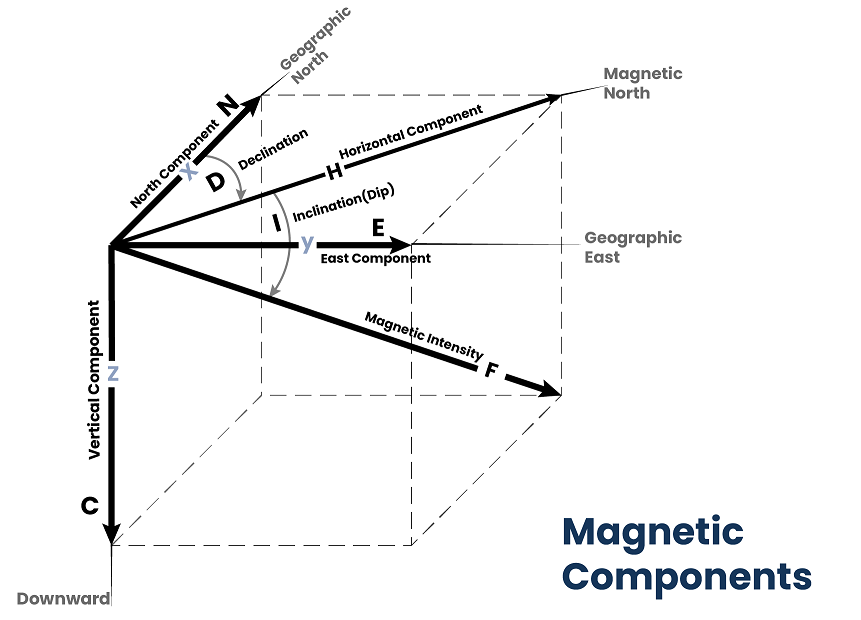


In [168]:
MagDataFinal= pd.concat([GeoMagParallelResult_Zero, NoZeroValues])
MagDataFinal.head()

,Latitude,Longitude,DateTime,Fgps,N,E,C,H,D,I,TotalPoints,MinDist,AvDist
0,57.427383,31.894067,2014-10-01 02:42:00,52102.884319,15444.077385,2699.635046,49688.056902,15678.251039,0.173052,1.265150,50,173.642413,844.927569
1,57.321483,31.669200,2014-10-01 02:59:00,52061.839343,15474.859340,2665.622952,49637.267234,15702.764639,0.170581,1.264408,51,188.018658,854.398465
2,57.195767,31.446667,2014-10-01 03:14:00,52017.092826,15556.354382,2642.681862,49566.057105,15779.224603,0.168272,1.262593,50,203.258382,849.222223
3,53.353933,19.858717,2014-10-01 14:38:00,49794.857074,17829.665513,1529.071515,46468.190830,17895.111958,0.085551,1.203196,38,107.478811,701.623768
4,53.324533,19.568867,2014-10-01 14:54:00,49751.815612,17861.152223,1503.119436,46410.807254,17924.288739,0.083958,1.202235,36,99.748146,667.786960


### Validating the final results for new outliers

Before mapping the final results, it would be useful to validate again we did not get any outlier and all the GPS Track rows have a proper Magnetic Values.

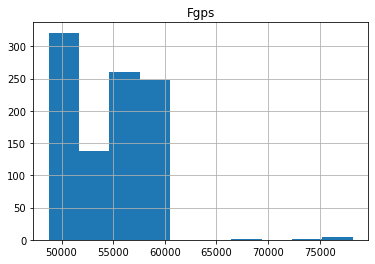

In [171]:
hist3 = GeoMagResults.hist(column='Fgps')

### Mapping the GPS Track using the annotated Magnetic Values (Optional)

Now we are going to plot the annotated GPS track stored into the MagDataFinal dataframe to see how the different magnetic components in a map to have a better prespective of the impact of the earth magnetic field.

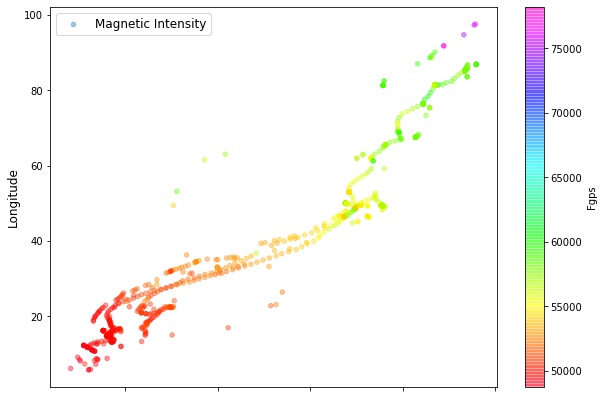

In [172]:
import matplotlib.pyplot as plt

MagDataFinal.plot(kind="scatter", x="Latitude", y="Longitude",
    label="Magnetic Intensity",
    c="Fgps", cmap=plt.get_cmap("gist_rainbow"),
    colorbar=True, alpha=0.4, figsize=(10,7)
    
)

plt.ylabel("Longitude", fontsize=12)
plt.xlabel("Latitude", fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [173]:
import geopandas
import geoplot
gdf = geopandas.GeoDataFrame(GeoMagResults, geometry=geopandas.points_from_xy(GeoMagResults.Longitude, GeoMagResults.Latitude))
gdf.head()

,Latitude,Longitude,DateTime,Fgps,N,E,C,H,D,I,TotalPoints,MinDist,AvDist,geometry
0,70.854717,68.307333,2014-09-08 05:54:00,58263.516606,6533.771524,3145.053928,57810.516628,7251.312608,25.704002,82.850591,21,327.950987,626.701218,POINT (68.30733 70.85472)
1,70.830300,67.975050,2014-09-08 06:10:00,58261.123705,6538.091436,3149.741775,57807.361318,7257.238653,25.722557,82.844422,21,340.038476,628.953831,POINT (67.97505 70.83030)
2,70.761717,67.752417,2014-09-08 06:26:00,58058.984855,6682.091934,3212.055102,57583.661501,7414.017169,25.673409,82.663410,26,348.223318,656.804069,POINT (67.75242 70.76172)
3,70.686517,67.561983,2014-09-08 06:42:00,58056.861413,6699.935204,3220.395629,57578.981212,7433.712380,25.671765,82.643543,26,355.472899,657.901776,POINT (67.56198 70.68652)
4,70.685450,67.548317,2014-09-08 07:14:00,58045.681746,6704.933680,3235.486162,57566.280608,7444.763687,25.759774,82.631119,26,355.980432,657.921513,POINT (67.54832 70.68545)


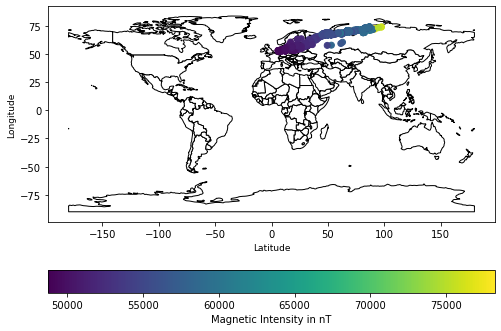

In [174]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# We restrict to South America.
ax = world.plot(color='white', edgecolor='black', figsize = (8,6))

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, column='Fgps', legend=True, 
         legend_kwds={'label': "Magnetic Intensity in nT",
                      'orientation': "horizontal"})
plt.ylabel("Longitude", fontsize=9)
plt.xlabel("Latitude", fontsize=9)

plt.show()

Text(567.7954545454544, 0.5, 'Longitude')

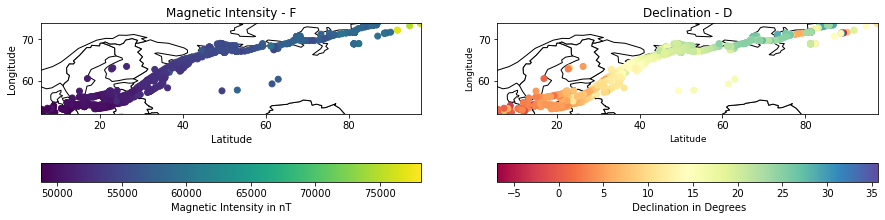

In [214]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,6))

ax1 = world.plot(ax=ax1, color='white', edgecolor='black')
xlim = ([gdf.total_bounds[0],  gdf.total_bounds[2]])
ylim = ([gdf.total_bounds[1],  gdf.total_bounds[3]])
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)


gdf.plot(ax=ax1, column='Fgps', legend=True,
         legend_kwds={'label': "Magnetic Intensity in nT",
                      'orientation': "horizontal"})
plt.ylabel("Longitude", fontsize=9)
plt.xlabel("Latitude", fontsize=9)
ax1.set_title('Magnetic Intensity - F')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitude')


ax2 = world.plot( ax=ax2, color='white', edgecolor='black')
xlim = ([gdf.total_bounds[0],  gdf.total_bounds[2]])
ylim = ([gdf.total_bounds[1],  gdf.total_bounds[3]])
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)


# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax2, column='D', legend=True, cmap='Spectral', 
         legend_kwds={'label': " Declination in Degrees",
                      'orientation': "horizontal"})
ax2.set_title('Declination - D')
ax2.set_xlabel('Latitude')
ax2.set_ylabel('Longitude')

### Exporting the annotated DF into a CSV file (Optional)


In [ ]:
#Exporting the CSV file
os.chdir('C:\\foss4guk19-jupyter-master\\Project_StAndrews\\VirES\\results')
outputfile ="GeoMag_"+gpsfilename
export_csv = MagDataFinal.to_csv (outputfile, index = None, header=True)

# Now over to you!


We hope this notebook will guide througth the whole process to annotate your GPS track with the earth' magnetic field components. You can now run **MagGeo** in several ways, using the online version, folk the Github repo, or simply download the noteboopk to run it in your enviroment. We have try our best to describe every step in **MagGeo** but if you still have some questions, comments or suggestions, we are more than happty to address them all. Please contact the authors, Fernando Benitez (Fernando.Benitez@st-andrews.ac.uk), Urska Demsar (demsar@st-andrews.ac.uk) or Jed Long (long@western.ca)

## Some useful links

- Vires for Swarm Client: https://vires.services/ 
- Vires for Swarm Documentation: https://viresclient.readthedocs.io/en/latest/access_token.html
- MagPy a Python package for analysing and displaying geomagnetic data: https://github.com/geomagpy/magpy
